In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math
import csv

In [11]:
def func(x):
    """Zadana funkcja: f(x) = exp(-3*sin(x)) + 3*cos(x)."""
    return np.array([math.exp(-3*math.sin(xi)) + 3*math.cos(xi) for xi in x])

def func_derivative(x):
    """
    Pochodna funkcji:
    f'(x) = -3*exp(-3*sin(x))*cos(x) - 3*sin(x).
    """
    return np.array([-3*math.exp(-3*math.sin(xi))*math.cos(xi) - 3*math.sin(xi) for xi in x])


In [12]:
def hermite_divided_difference_table(x, y, dy):
    """
    Buduje tablicę różnic dzielonych dla interpolacji Hermite’a.
    
    Parametry:
      x  - wektor węzłów (długość n),
      y  - wartości funkcji w węzłach (długość n),
      dy - wartości pochodnych w węzłach (długość n)
      
    Zwraca:
      z - wektor 2n-elementowy, w którym każdy węzeł jest powtórzony,
      Q - tablica różnic dzielonych, w której przy powtarzanych węzłach 
          pierwsza różnica to wartość pochodnej.
    """
    n = len(x)
    m = 2 * n
    z = np.zeros(m)
    Q = np.zeros((m, m))
    
    # Uzupełnienie węzłów i wartości – każdy węzeł powtarzamy dwukrotnie
    for i in range(n):
        z[2*i]   = x[i]
        z[2*i+1] = x[i]
        Q[2*i, 0]   = y[i]
        Q[2*i+1, 0] = y[i]
    
    # Obliczanie pierwszej kolumny różnic dzielonych
    for i in range(1, m):
        if np.isclose(z[i], z[i-1]):
            # Jeśli mamy powtórzony węzeł, to zamiast dzielenia podstawiamy pochodną
            Q[i, 1] = dy[i//2]
        else:
            Q[i, 1] = (Q[i, 0] - Q[i-1, 0]) / (z[i] - z[i-1])
    
    # Obliczanie kolejnych różnic dzielonych
    for j in range(2, m):
        for i in range(j, m):
            if np.isclose(z[i], z[i-j]):
                # W przypadku braku dodatkowych informacji (wyższych pochodnych) ustawiamy 0
                Q[i, j] = 0.0
            else:
                Q[i, j] = (Q[i, j-1] - Q[i-1, j-1]) / (z[i] - z[i-j])
    return z, Q

In [13]:
def hermite_interpolation(x_val, x, y, dy):
    """
    Oblicza wartość interpolowanego wielomianu Hermite’a dla pojedynczego punktu x_val
    przy użyciu tablicy różnic dzielonych.
    """
    z, Q = hermite_divided_difference_table(x, y, dy)
    m = len(z)
    # Schemat Hornera do ewaluacji wielomianu
    result = Q[m-1, m-1]
    for i in range(m-2, -1, -1):
        result = result * (x_val - z[i]) + Q[i, i]
    return result

def hermite_interpolation_vectorized(x_vals, x, y, dy):
    """Wektorowa wersja interpolacji Hermite’a."""
    return np.array([hermite_interpolation(xi, x, y, dy) for xi in x_vals])

In [14]:
def chebyshev_nodes(a, b, n):
    """Generuje węzły Czebyszewa dla przedziału [a, b]."""
    i = np.arange(1, n + 1)
    nodes = np.cos((2 * i - 1) * np.pi / (2 * n))
    nodes = 0.5 * (b - a) * (nodes + 1) + a
    return nodes

def uniform_nodes(a, b, n):
    """Generuje n równomiernych węzłów w przedziale [a, b]."""
    return np.linspace(a, b, n)


In [15]:
def calculate_max_and_mean_error(function, x_vals, x_nodes, y_nodes, dy_nodes):
    """
    Oblicza błąd maksymalny i średni dla interpolacji Hermite’a.
    """
    y_true = function(x_vals)
    y_interp = hermite_interpolation_vectorized(x_vals, x_nodes, y_nodes, dy_nodes)
    errors = y_true - y_interp
    max_error = np.max(np.abs(errors))
    mean_error = np.sqrt(np.sum(errors**2) / len(x_vals))
    return max_error, mean_error

In [16]:
def plot_interpolation_hermite_uniform(a, b, n, func, func_deriv, csv_writer=None):
    """
    Rysuje interpolację Hermite’a przy użyciu równomiernych węzłów oraz zapisuje błędy do CSV.
    """
    x_nodes = uniform_nodes(a, b, n)
    y_nodes = func(x_nodes)
    dy_nodes = func_deriv(x_nodes)

    x_plot = np.linspace(a, b, 500)
    y_true = func(x_plot)
    y_interp = hermite_interpolation_vectorized(x_plot, x_nodes, y_nodes, dy_nodes)

    max_error, mean_error = calculate_max_and_mean_error(func, x_plot, x_nodes, y_nodes, dy_nodes)

    if csv_writer is not None:
        csv_writer.writerow([
            n,
            "Hermite",
            "Równomierne",
            f"{mean_error:.6e}",
            f"{max_error:.6e}"
        ])

    plt.figure(figsize=(10, 6))
    plt.plot(x_plot, y_true, label="Funkcja", color='blue')
    plt.plot(x_plot, y_interp, label="Hermite (równomierne)", color='orange')
    plt.scatter(x_nodes, y_nodes, label="Węzły", zorder=5, color='orange')
    plt.legend()
    plt.title(f"Hermite, n={n} (węzły równomierne)\nBłąd max: {max_error:.3e}, błąd średni: {mean_error:.3e}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()

def plot_interpolation_hermite_chebyshev(a, b, n, func, func_deriv, csv_writer=None):
    """
    Rysuje interpolację Hermite’a przy użyciu węzłów Czebyszewa oraz zapisuje błędy do CSV.
    """
    x_nodes = chebyshev_nodes(a, b, n)
    y_nodes = func(x_nodes)
    dy_nodes = func_deriv(x_nodes)

    x_plot = np.linspace(a, b, 500)
    y_true = func(x_plot)
    y_interp = hermite_interpolation_vectorized(x_plot, x_nodes, y_nodes, dy_nodes)

    max_error, mean_error = calculate_max_and_mean_error(func, x_plot, x_nodes, y_nodes, dy_nodes)

    if csv_writer is not None:
        csv_writer.writerow([
            n,
            "Hermite",
            "Czebyszew",
            f"{mean_error:.6e}",
            f"{max_error:.6e}"
        ])

    plt.figure(figsize=(10, 6))
    plt.plot(x_plot, y_true, label="Funkcja", color='blue')
    plt.plot(x_plot, y_interp, label="Hermite (Czebyszew)", color='green')
    plt.scatter(x_nodes, y_nodes, label="Węzły Czebyszewa", zorder=5, color='green')
    plt.legend()
    plt.title(f"Hermite, n={n} (węzły Czebyszewa)\nBłąd max: {max_error:.3e}, błąd średni: {mean_error:.3e}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()


Interpolacja Hermite'a, n = 3


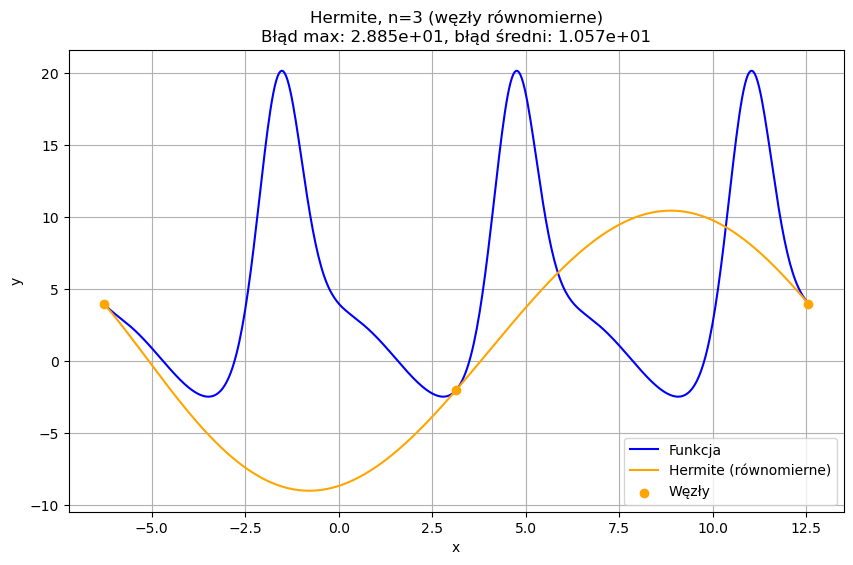

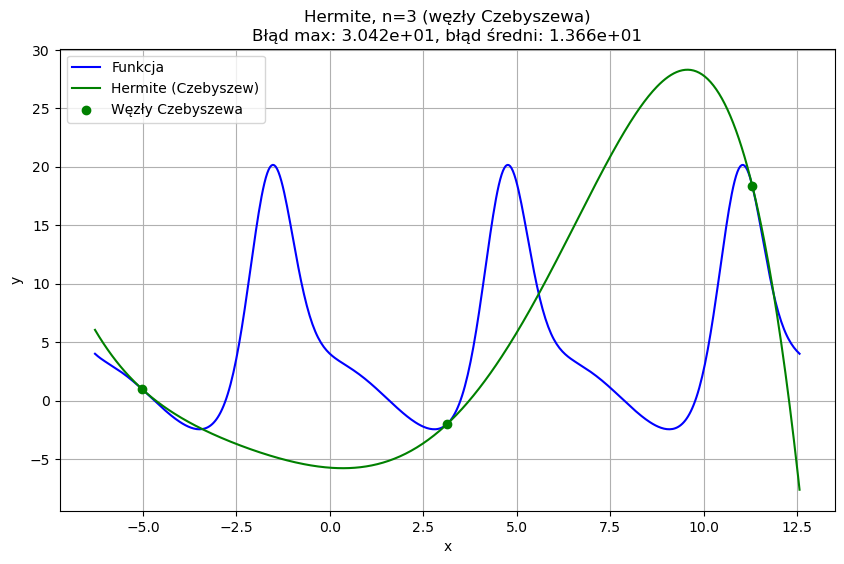


Interpolacja Hermite'a, n = 4


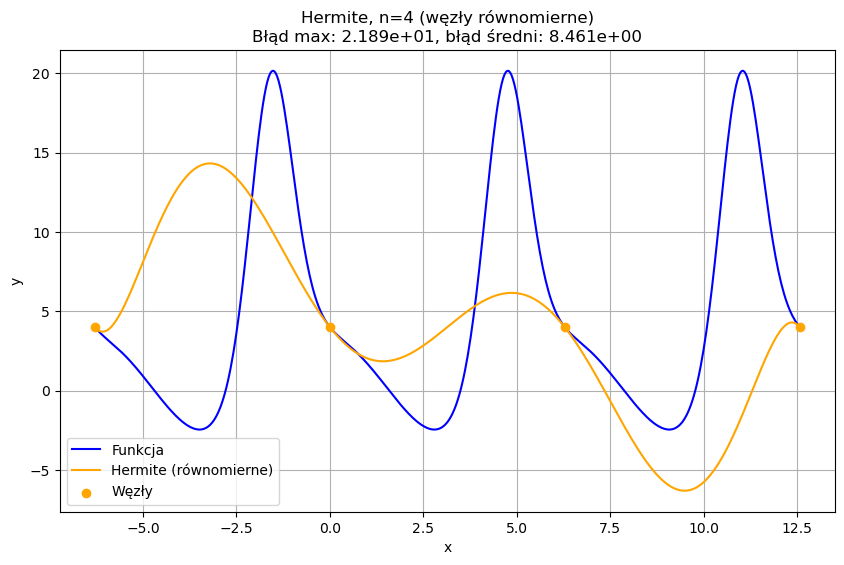

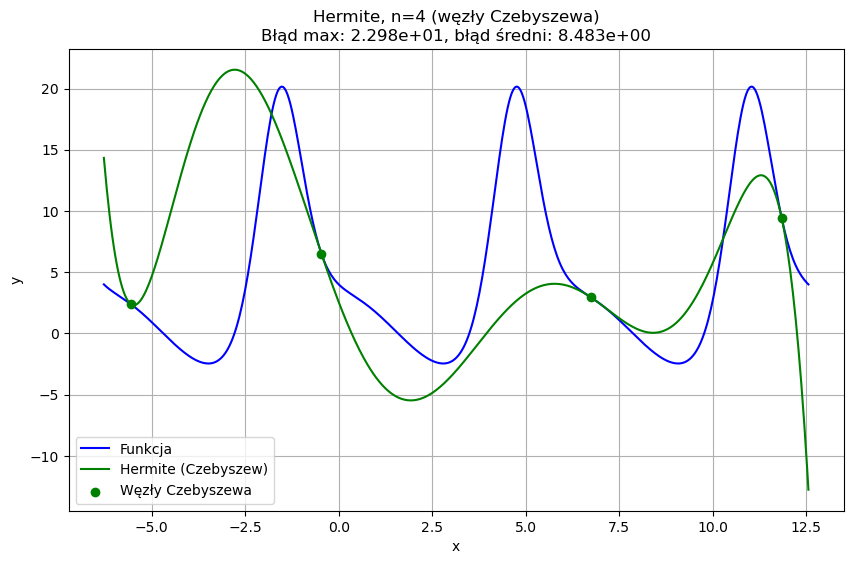


Interpolacja Hermite'a, n = 5


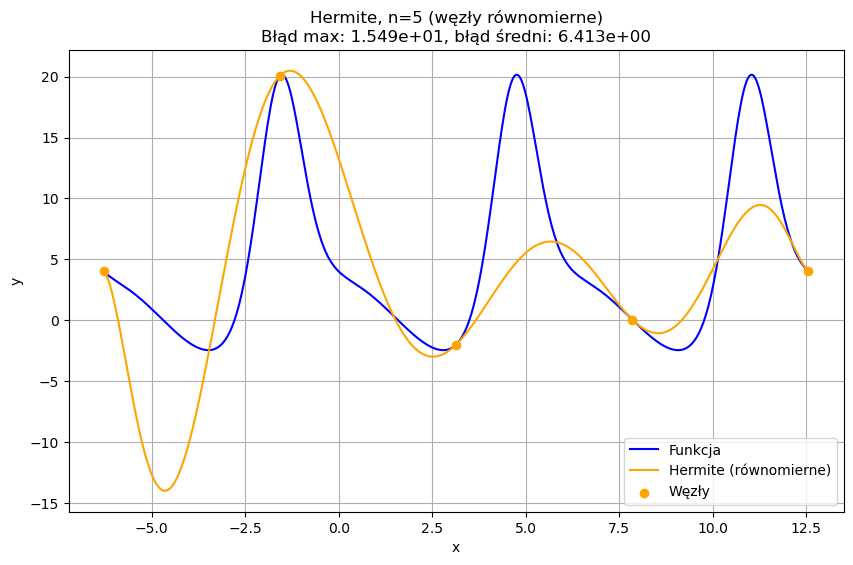

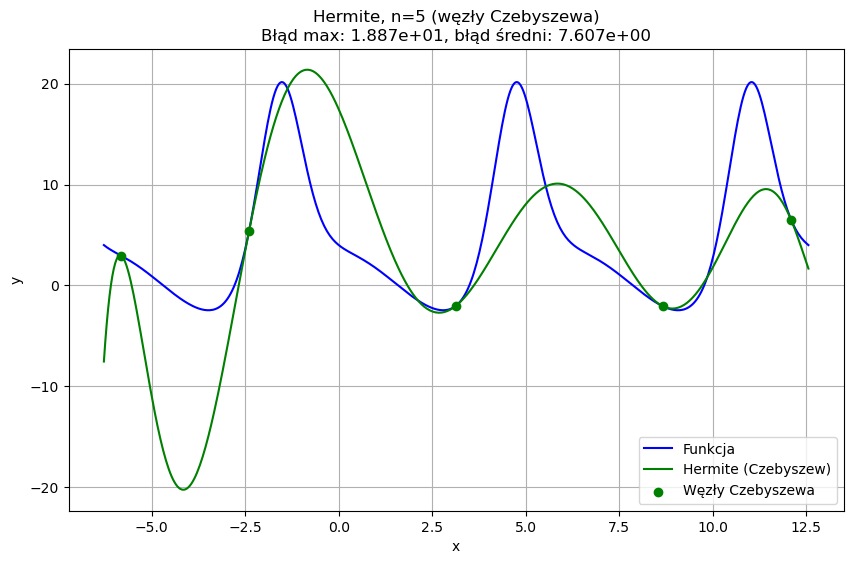


Interpolacja Hermite'a, n = 6


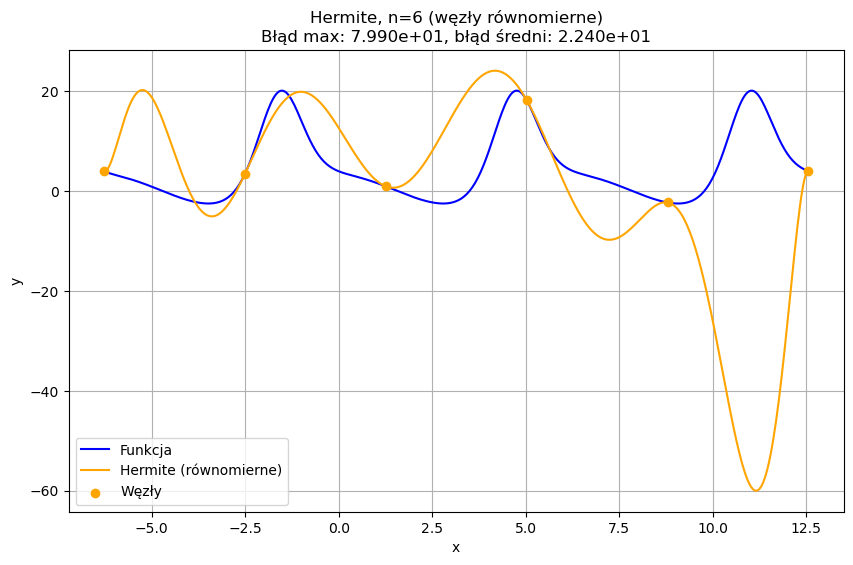

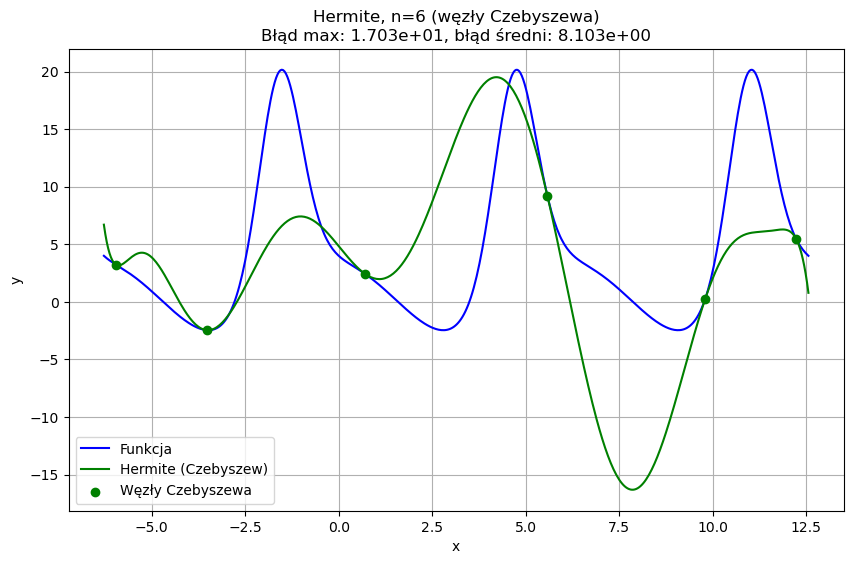


Interpolacja Hermite'a, n = 7


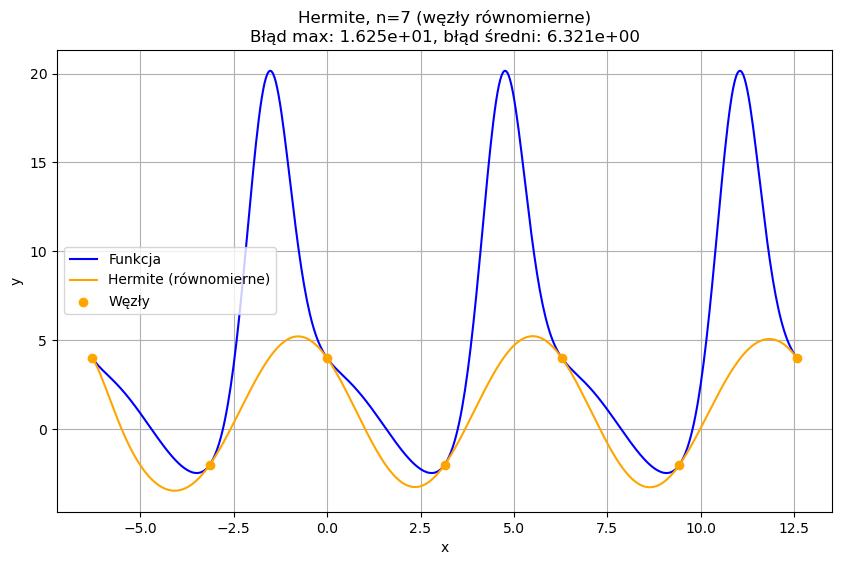

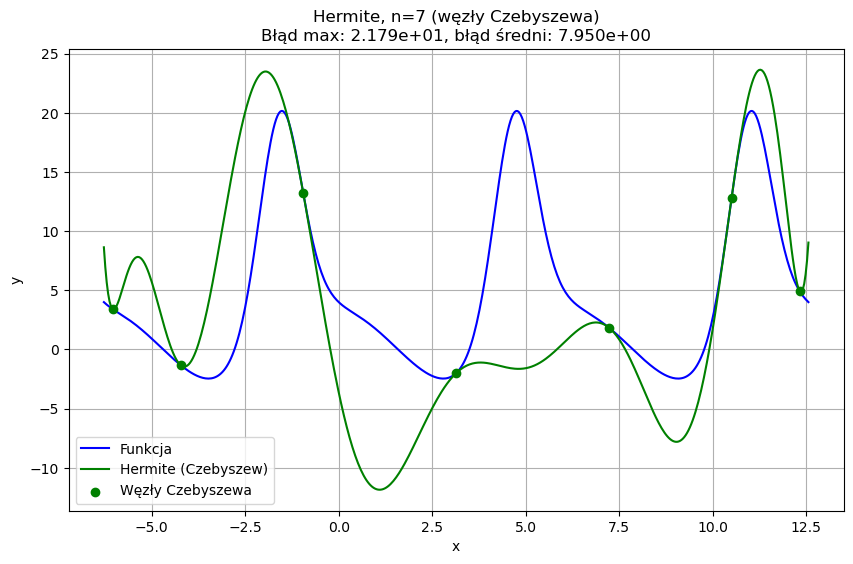


Interpolacja Hermite'a, n = 8


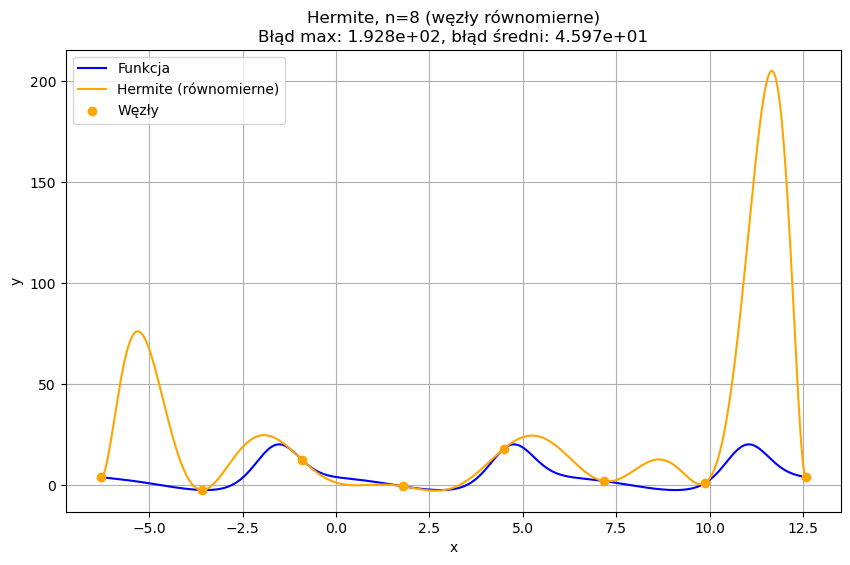

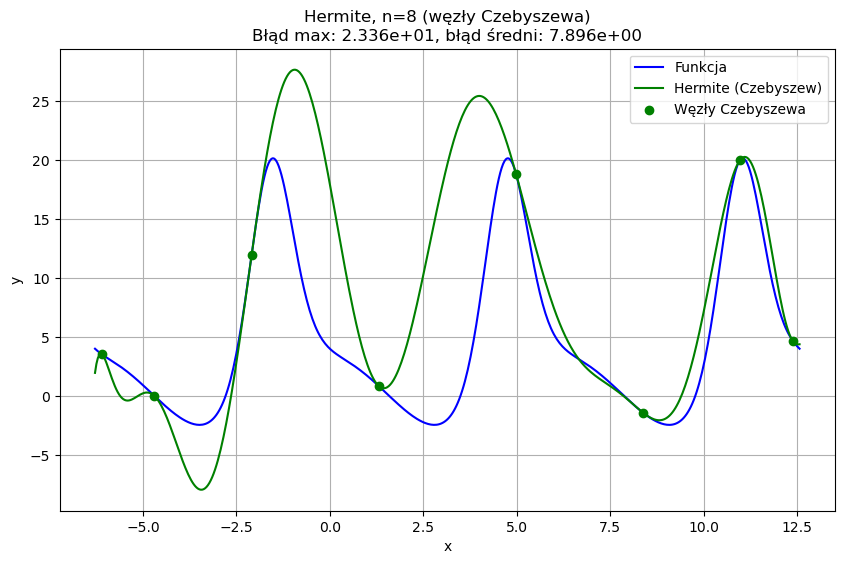


Interpolacja Hermite'a, n = 9


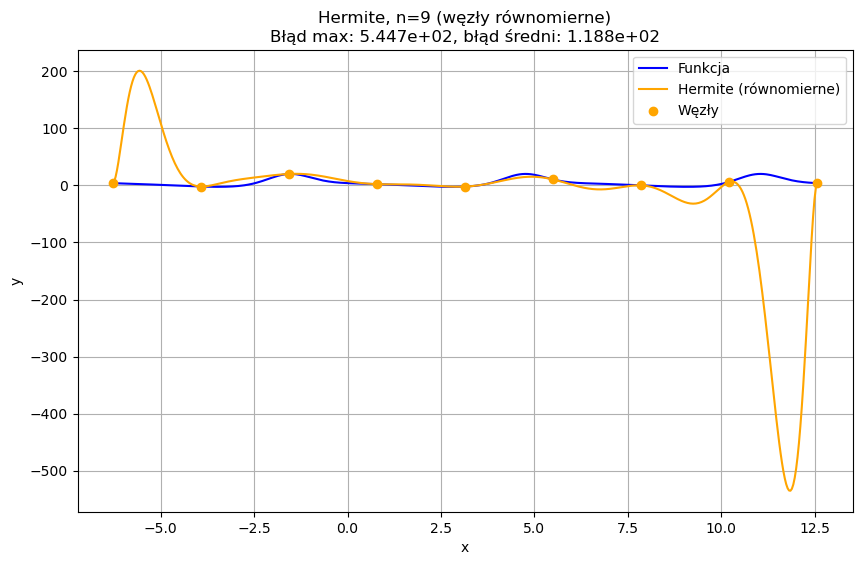

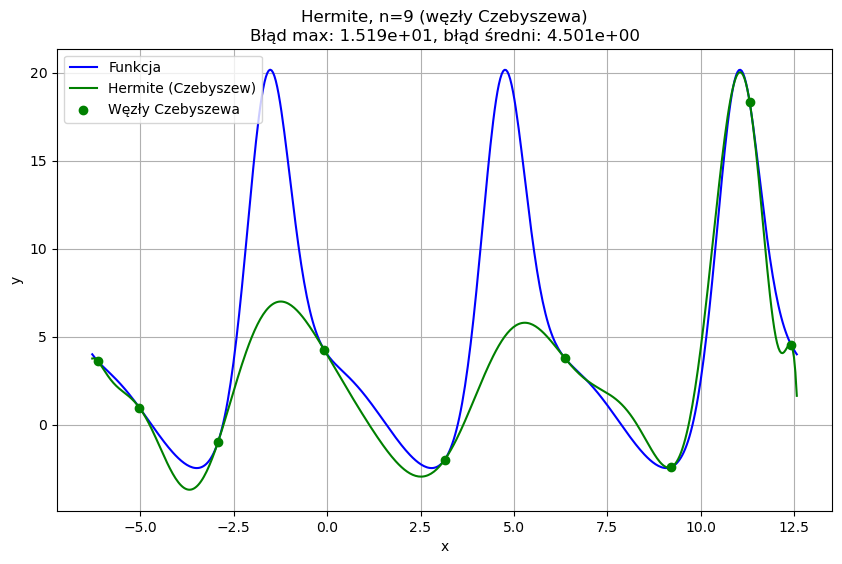


Interpolacja Hermite'a, n = 10


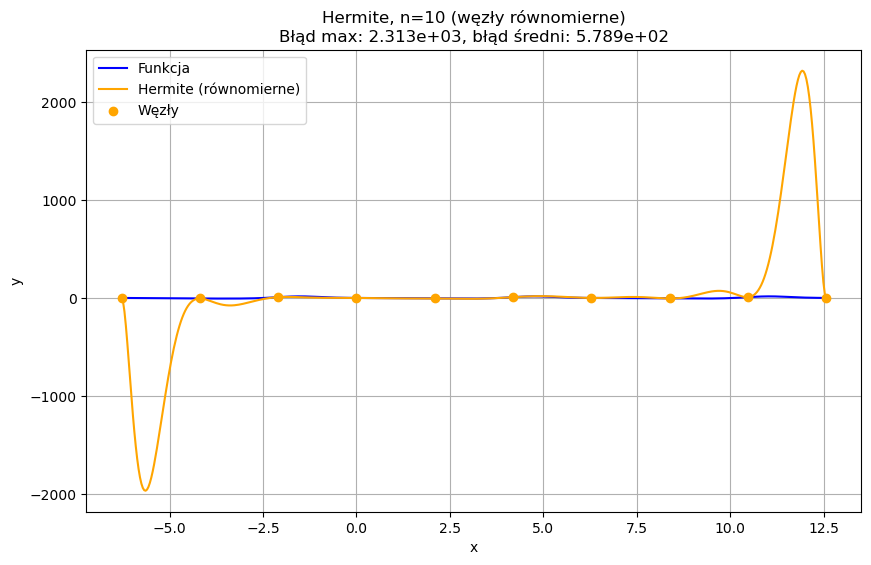

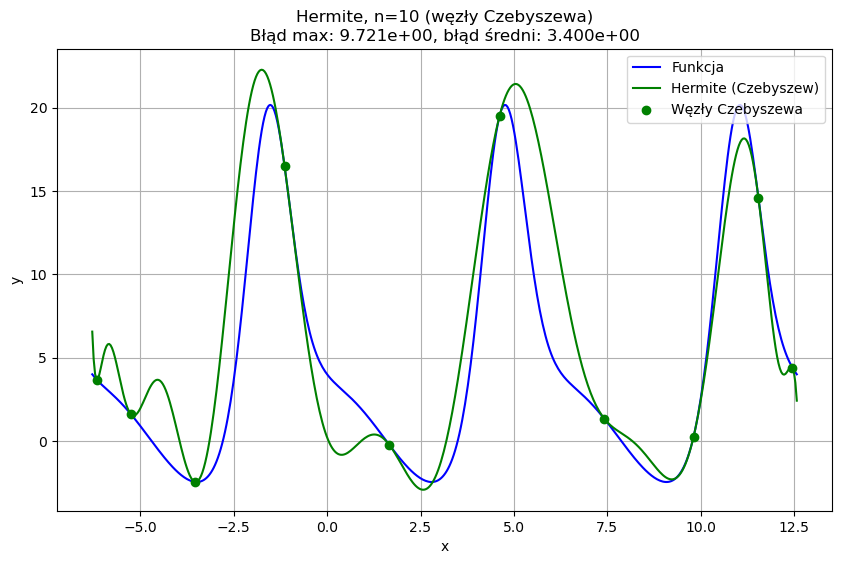


Interpolacja Hermite'a, n = 11


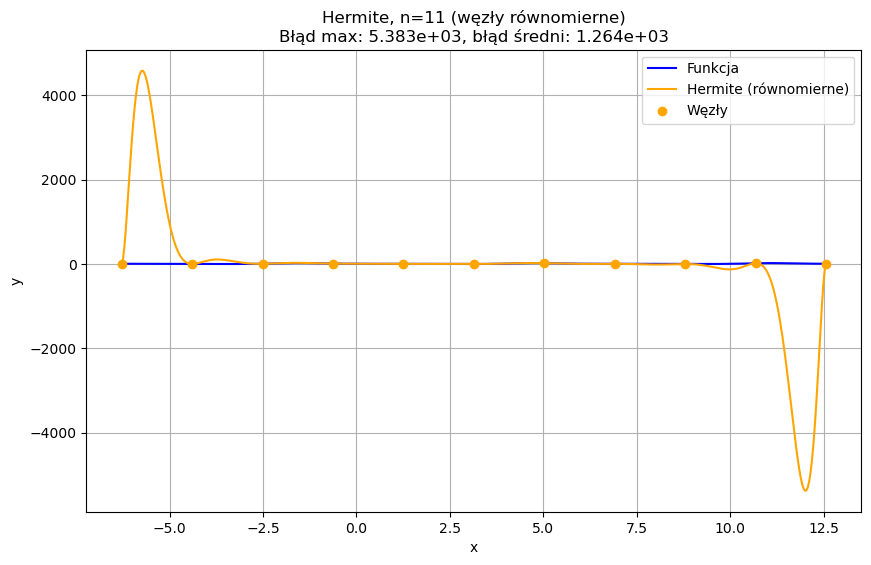

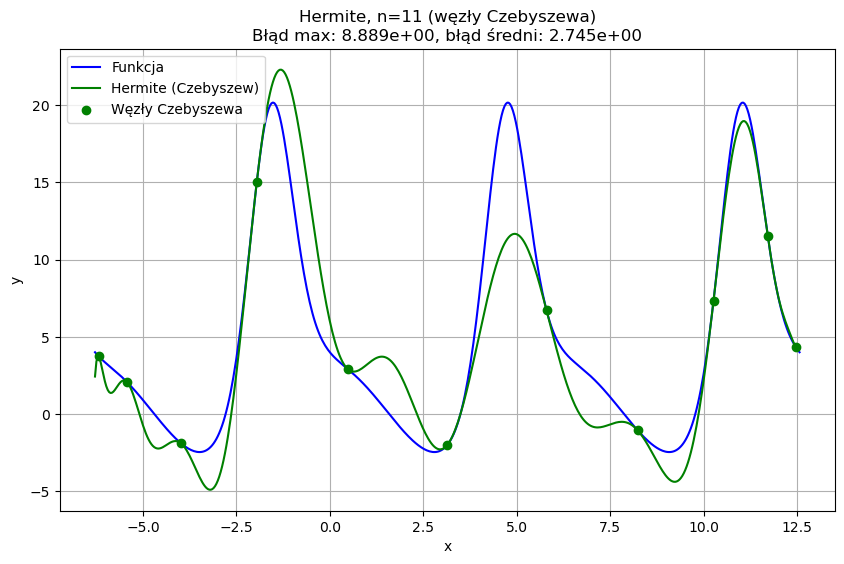


Interpolacja Hermite'a, n = 12


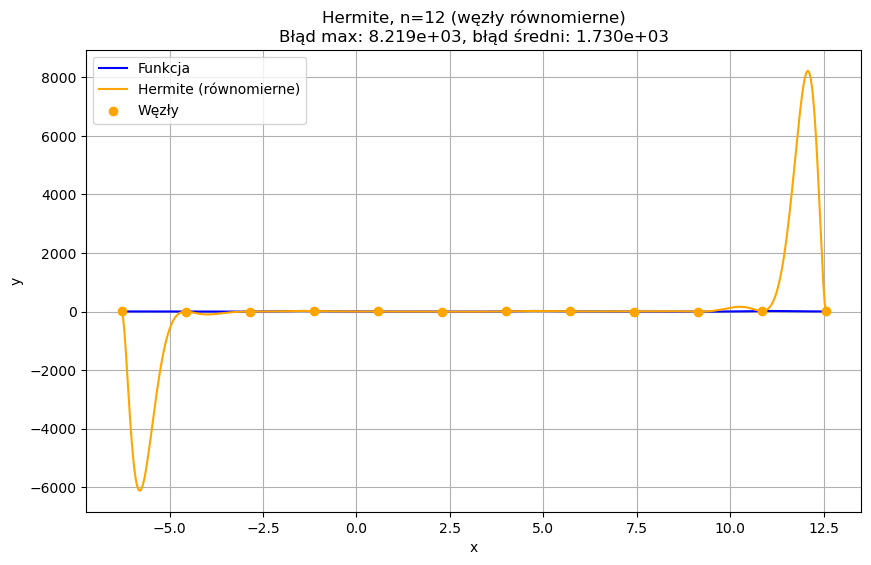

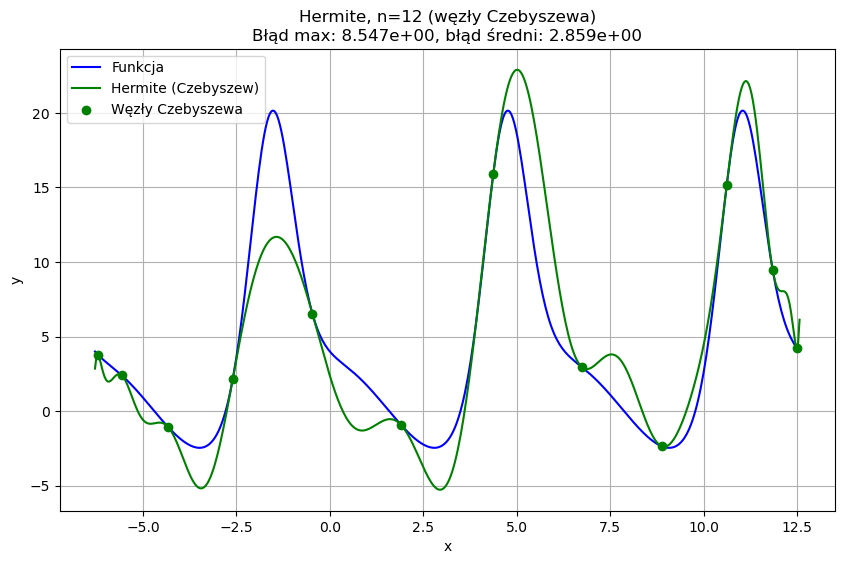


Interpolacja Hermite'a, n = 13


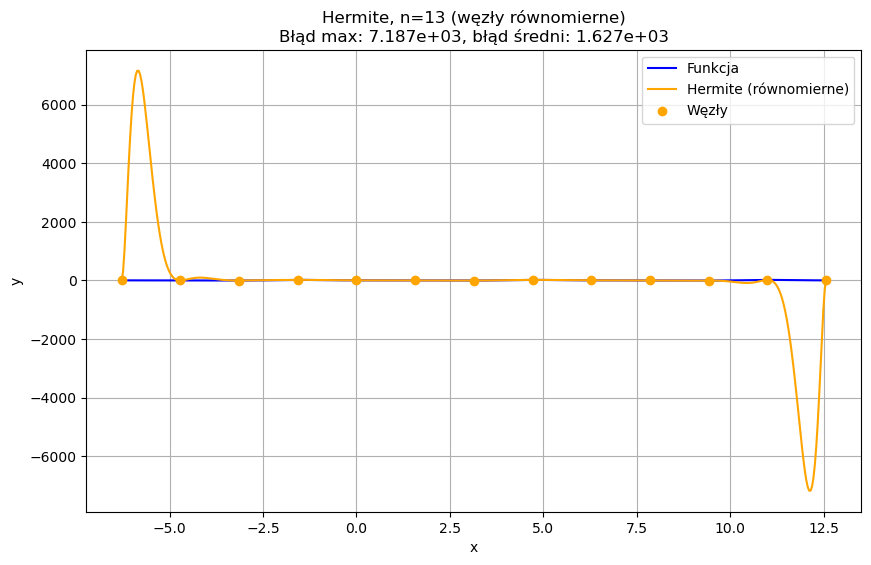

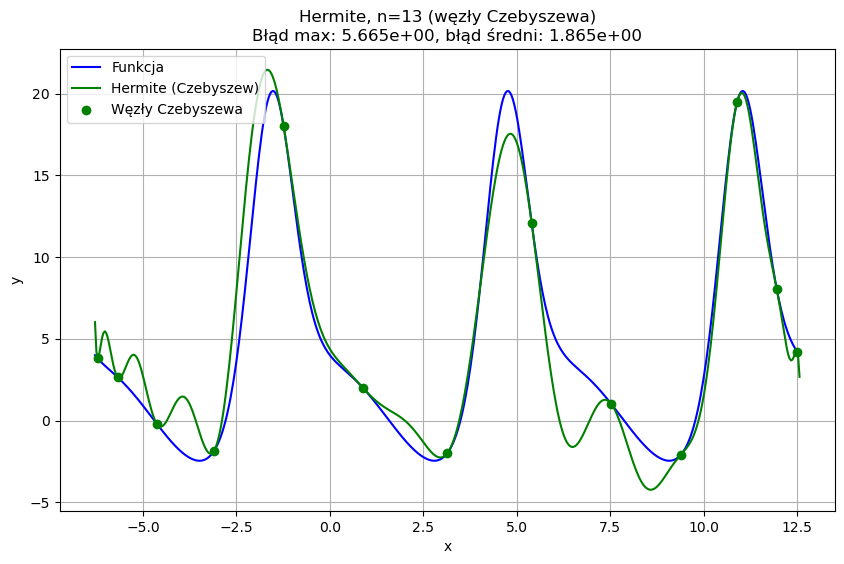


Interpolacja Hermite'a, n = 14


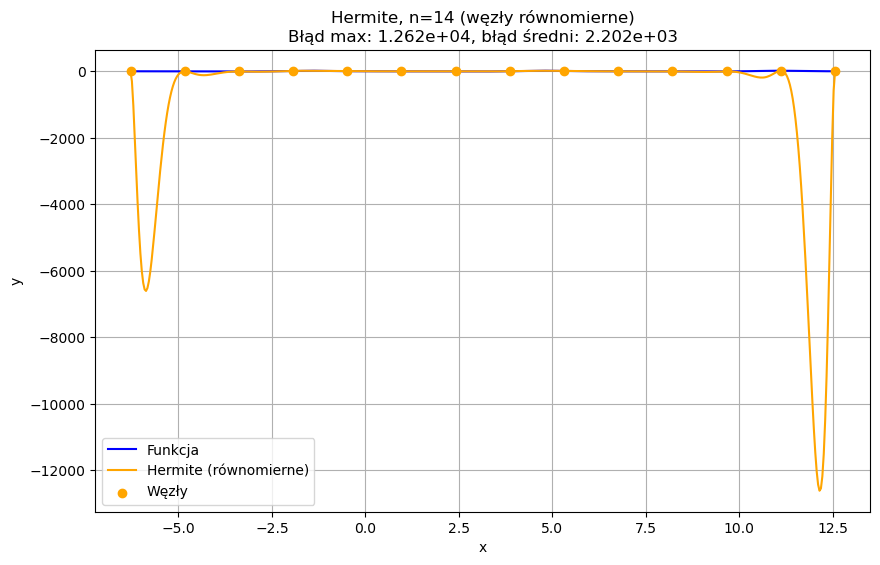

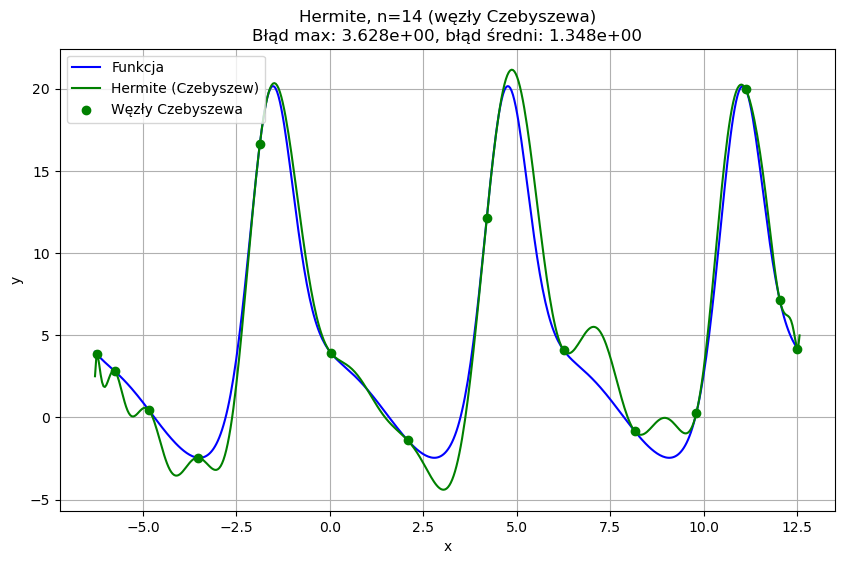


Interpolacja Hermite'a, n = 15


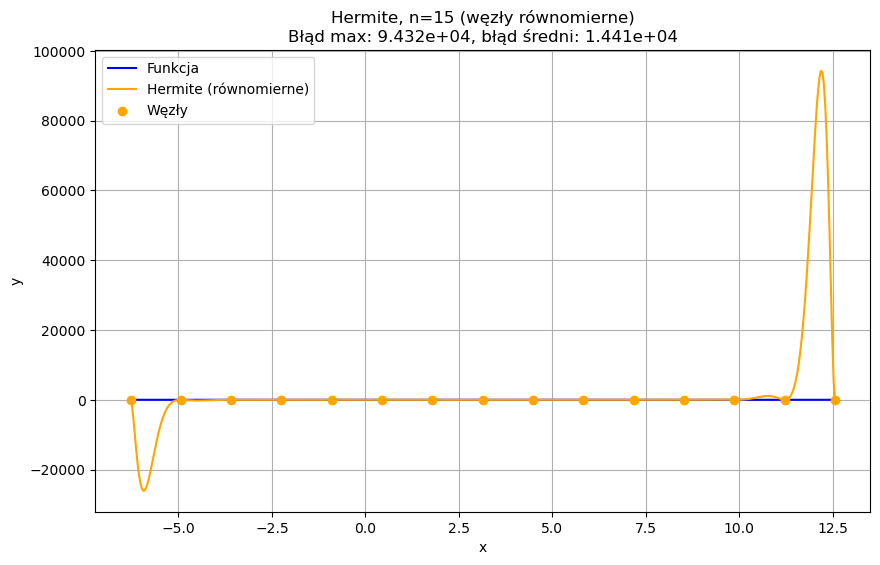

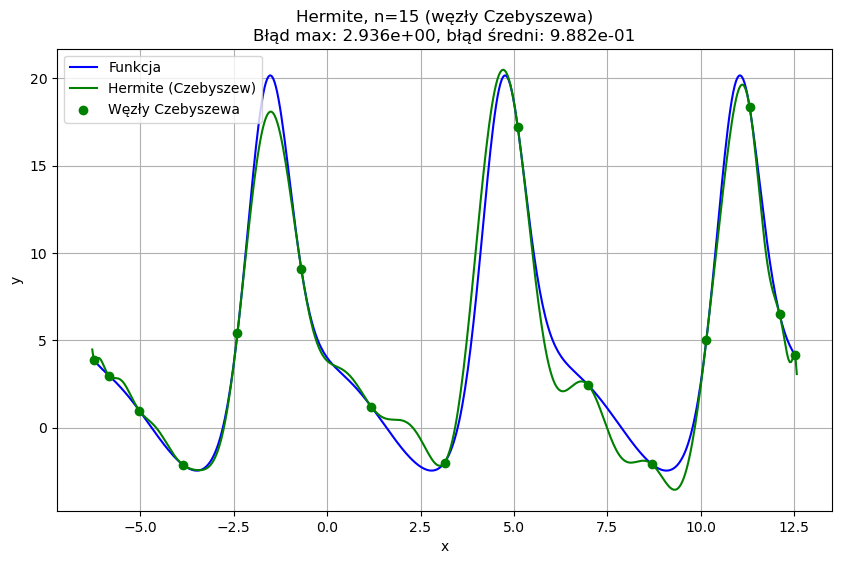


Interpolacja Hermite'a, n = 16


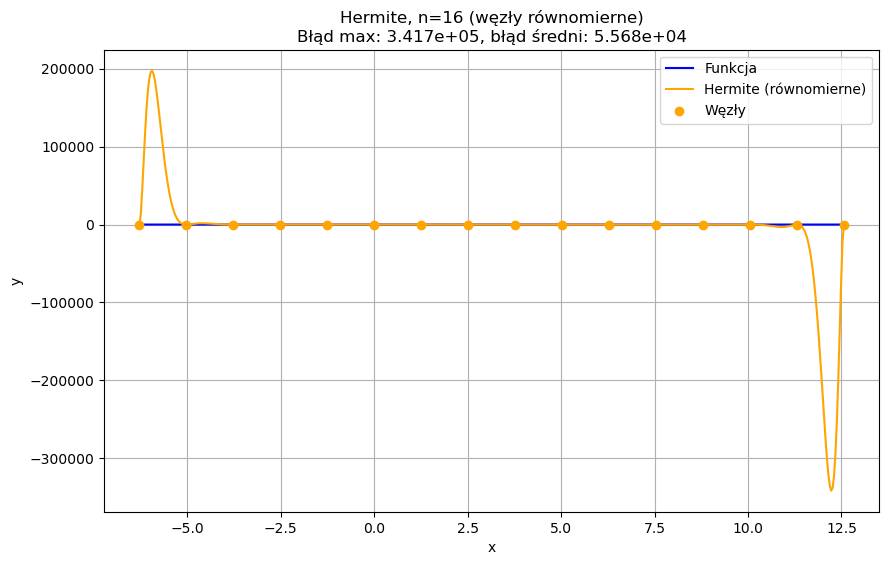

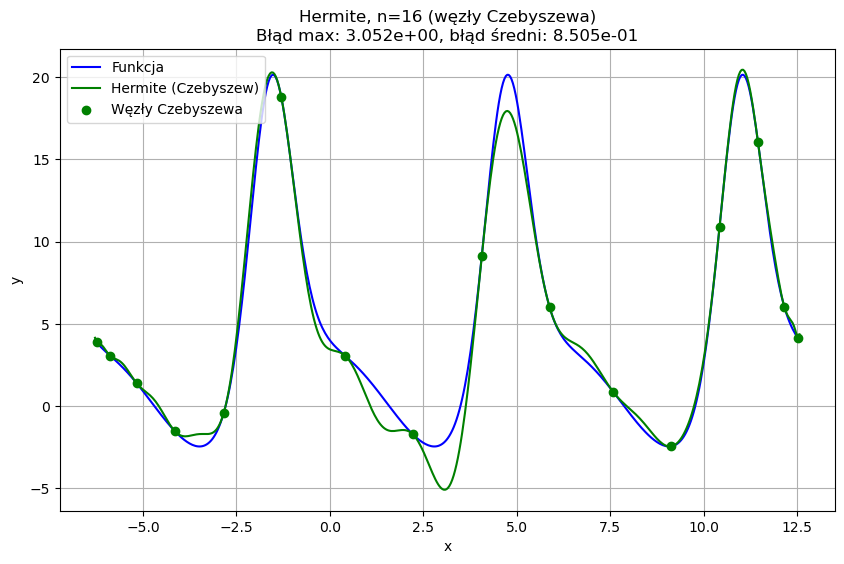


Interpolacja Hermite'a, n = 17


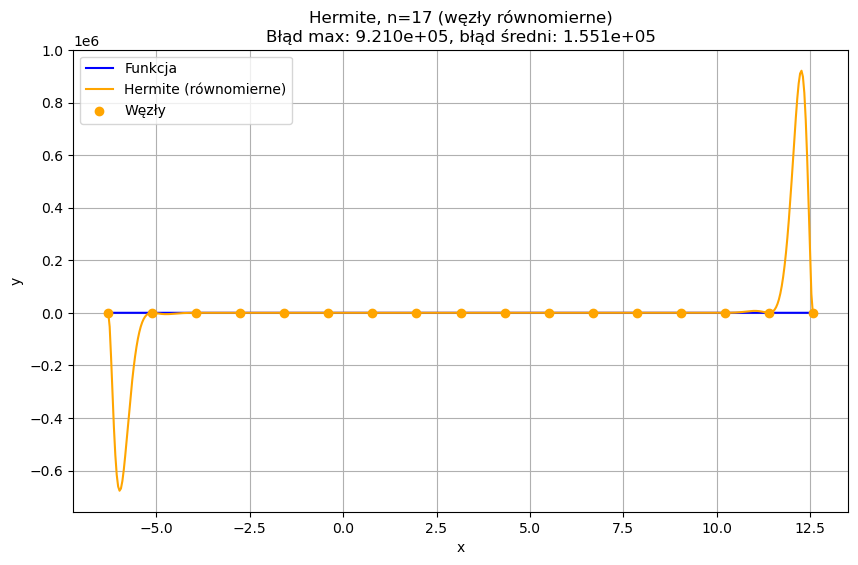

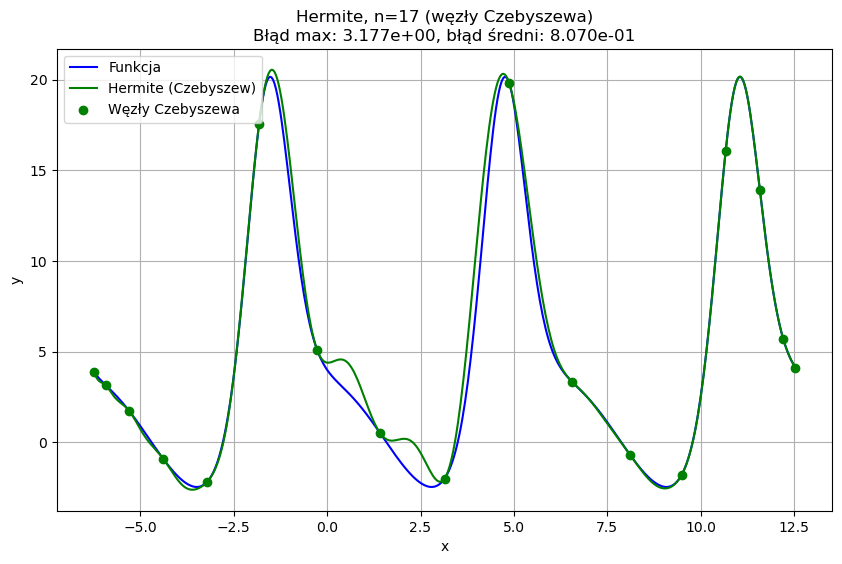


Interpolacja Hermite'a, n = 18


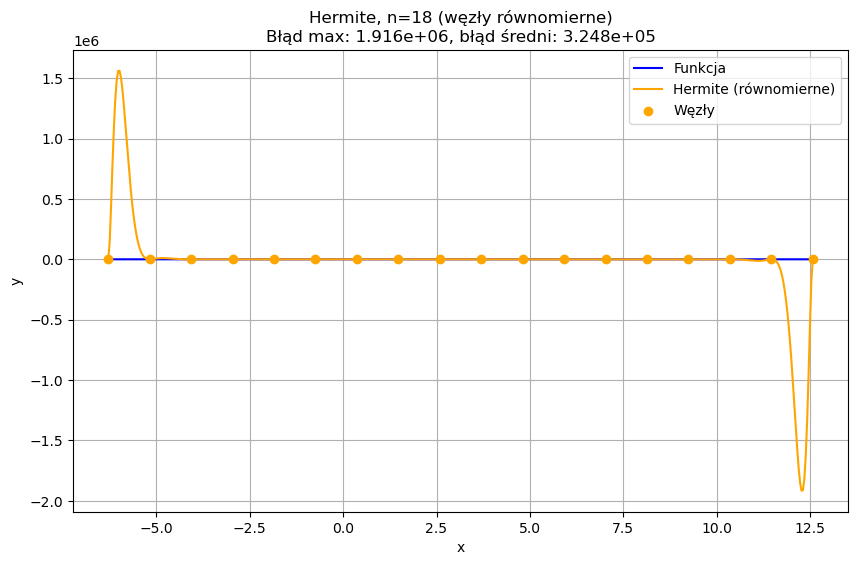

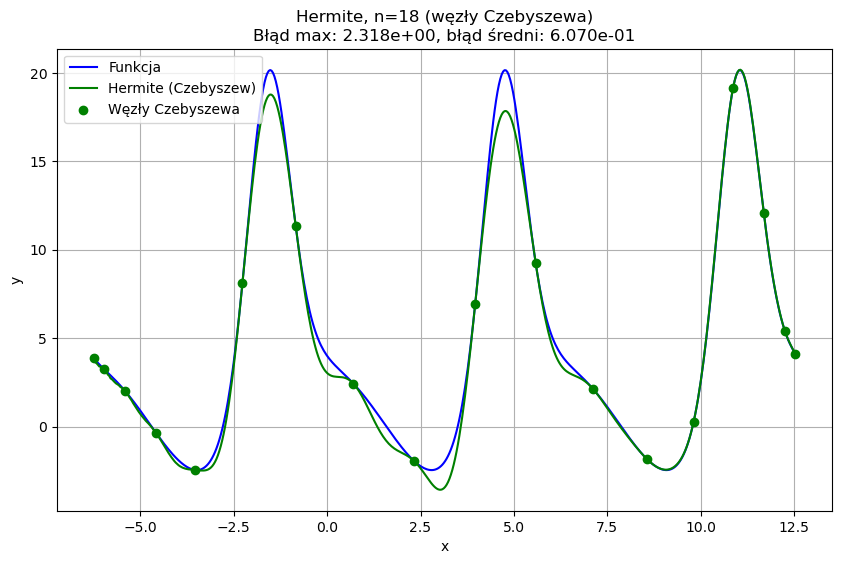


Interpolacja Hermite'a, n = 19


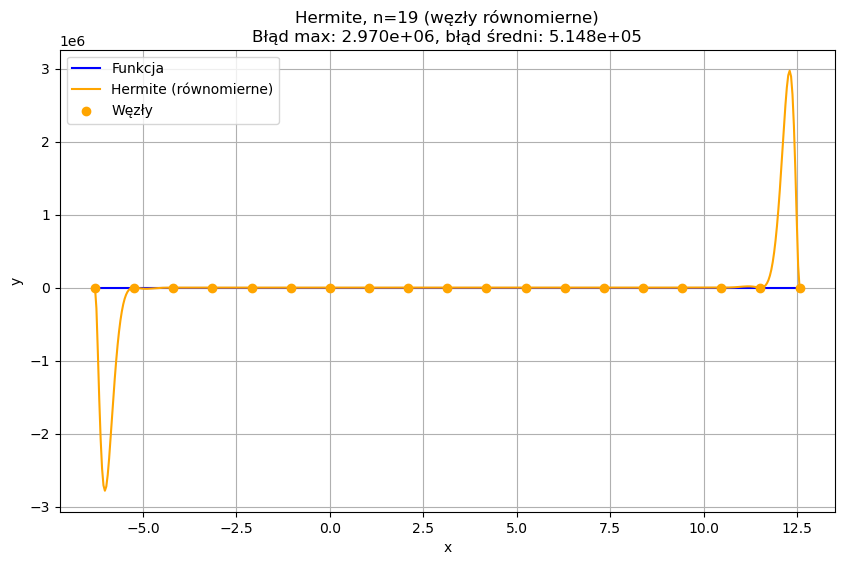

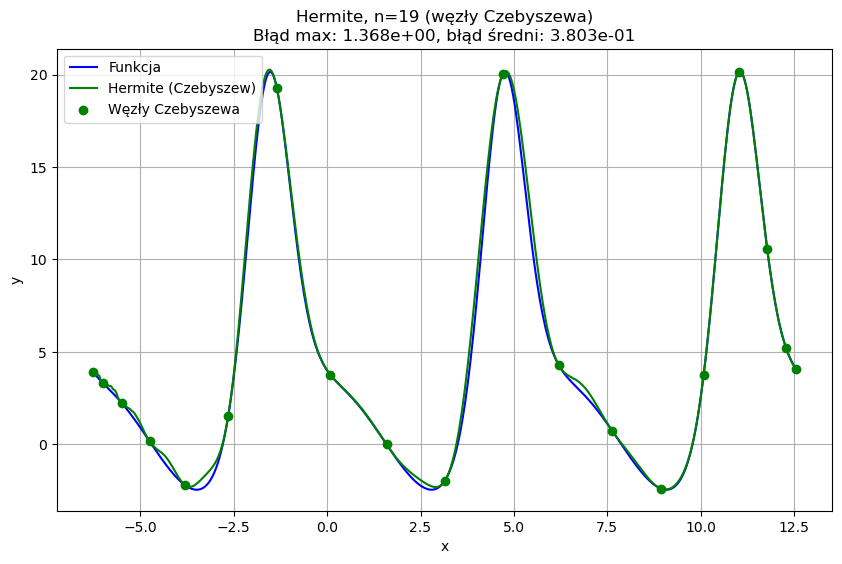


Interpolacja Hermite'a, n = 20


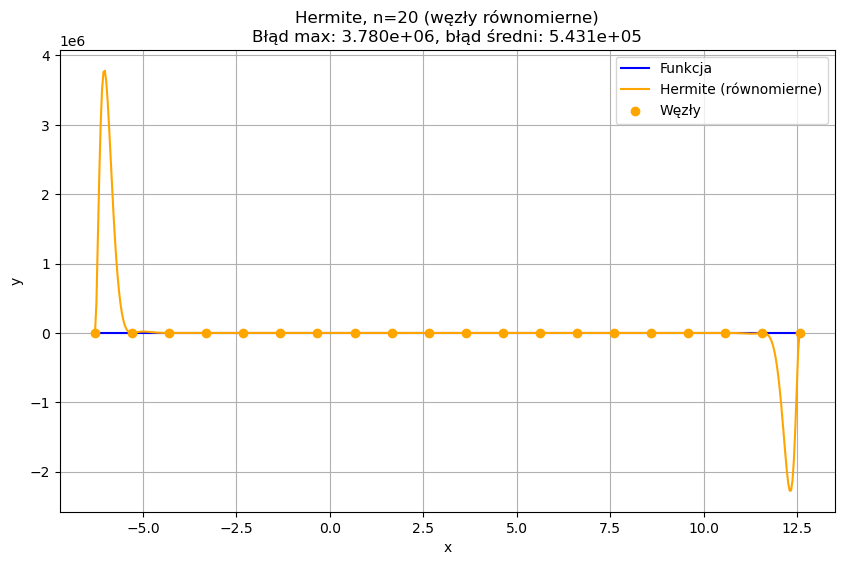

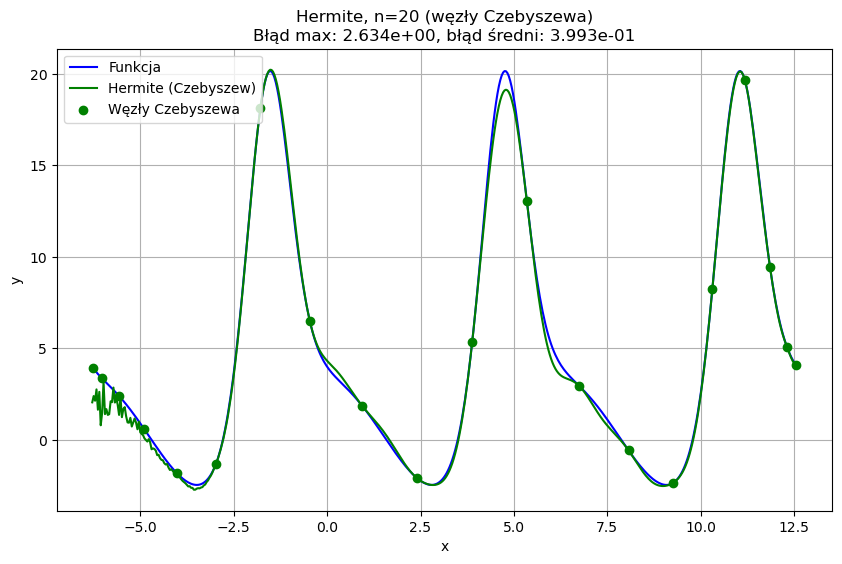


Interpolacja Hermite'a, n = 21


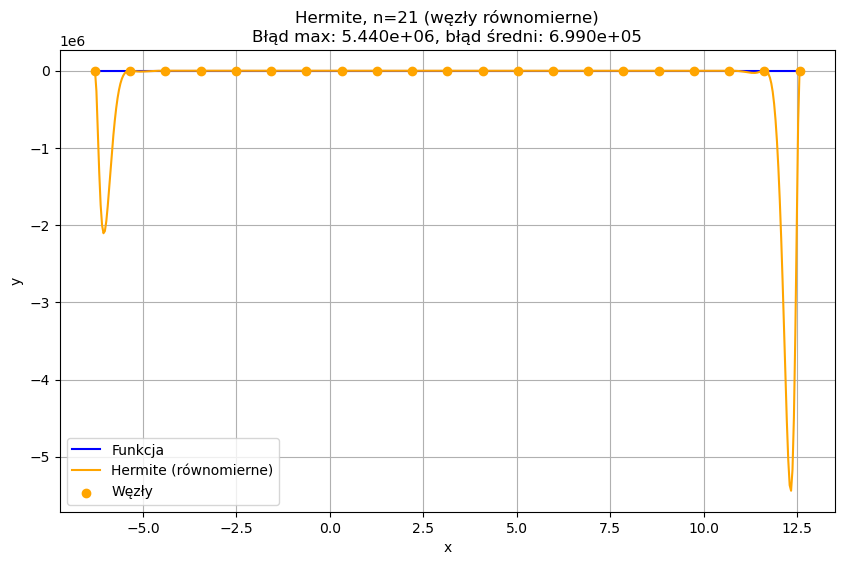

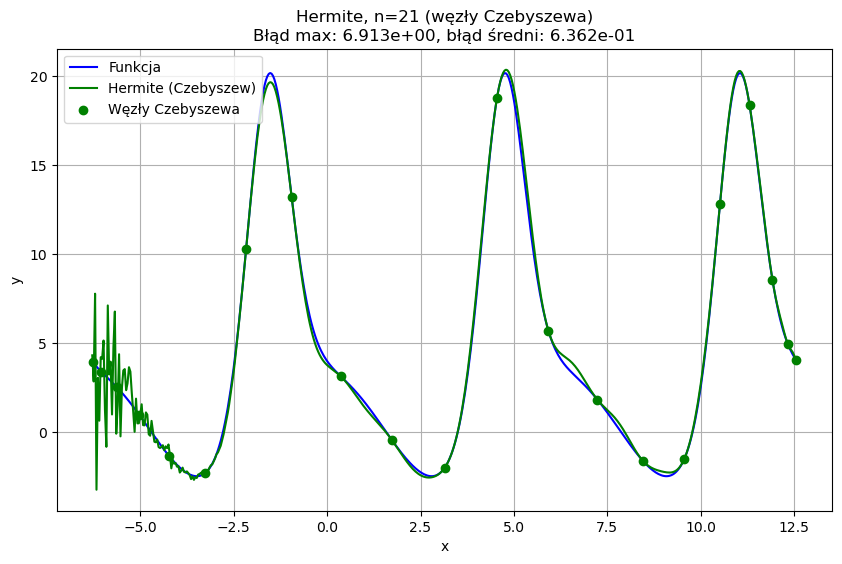


Interpolacja Hermite'a, n = 22


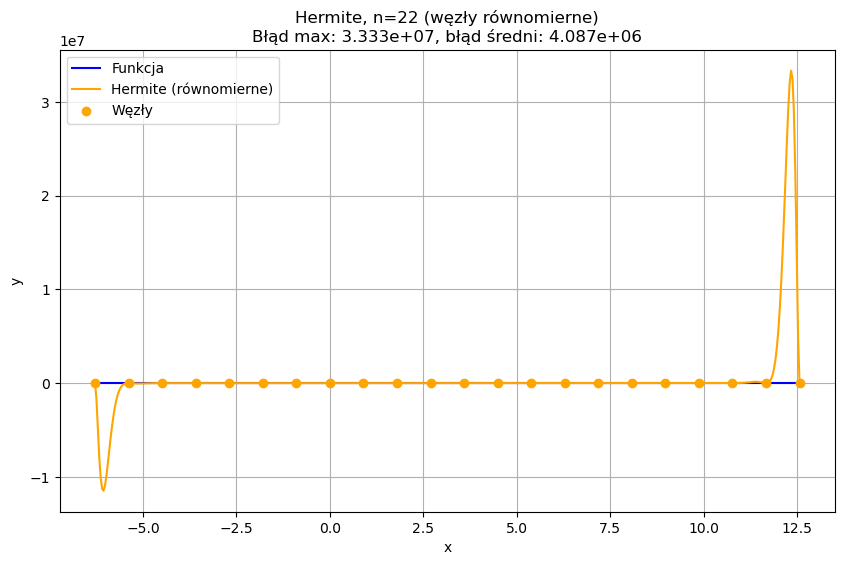

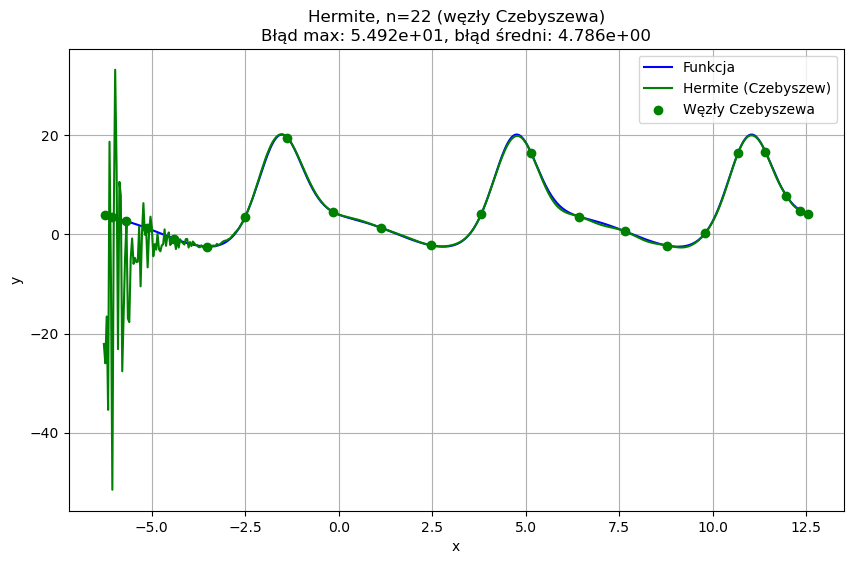


Interpolacja Hermite'a, n = 23


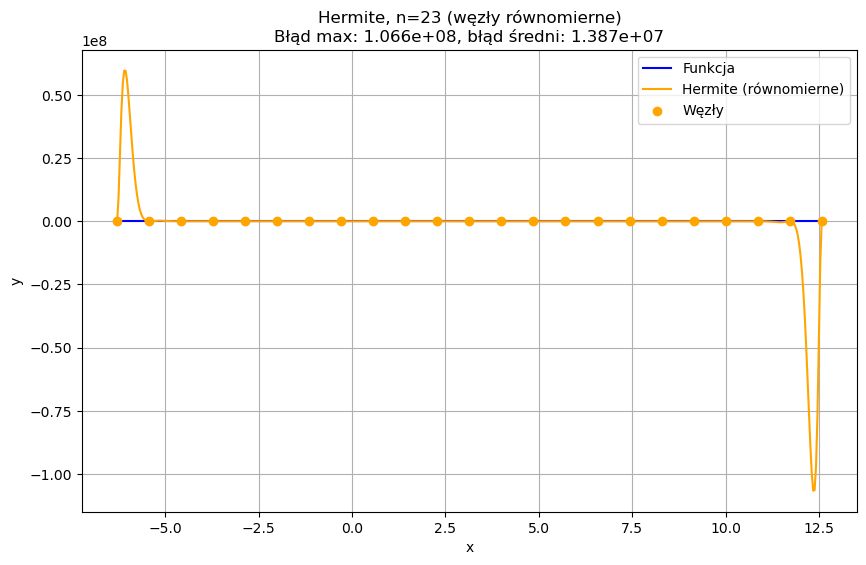

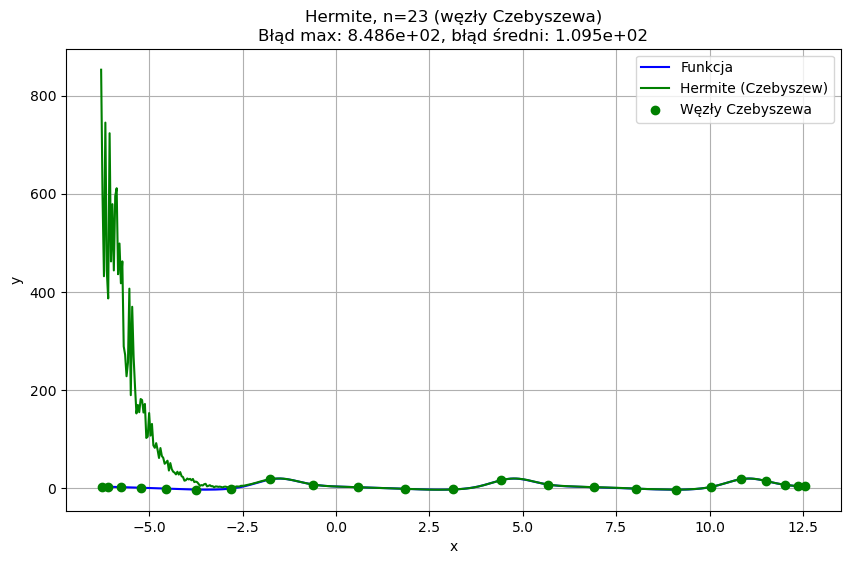


Interpolacja Hermite'a, n = 24


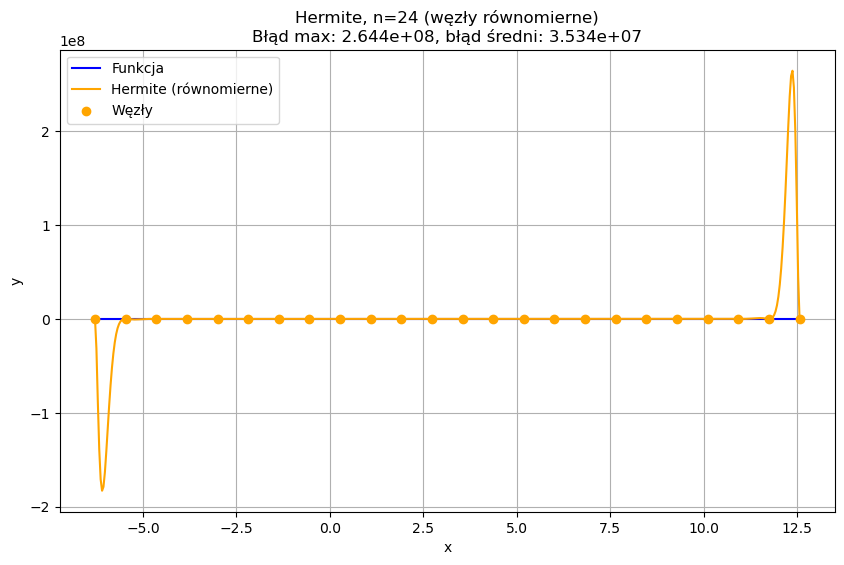

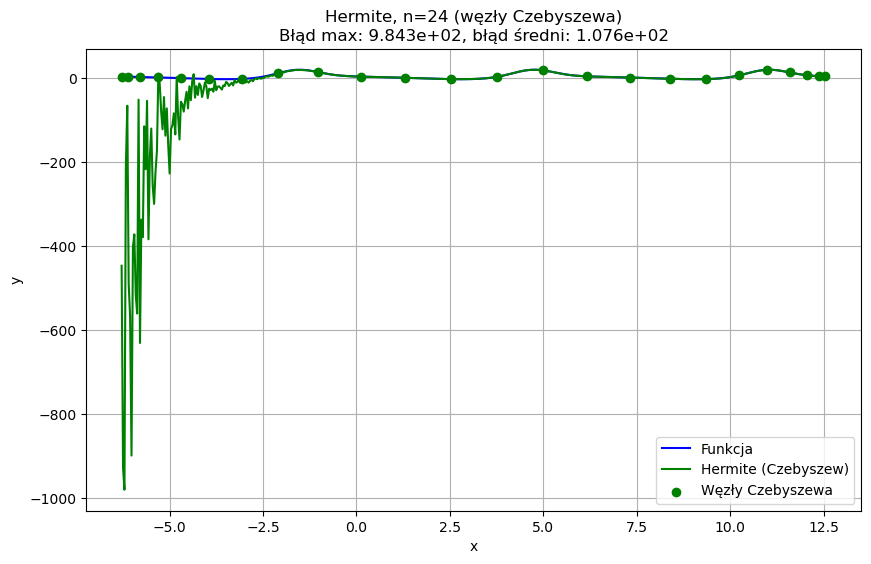


Interpolacja Hermite'a, n = 25


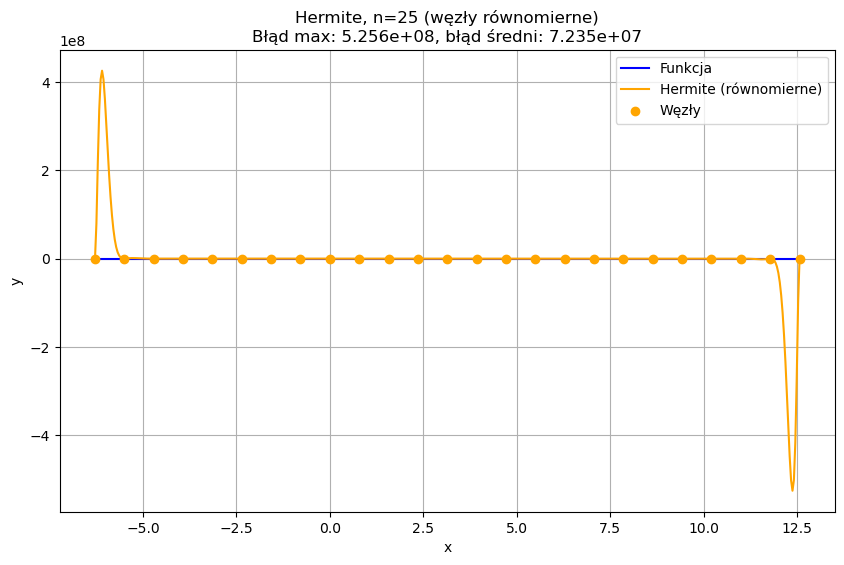

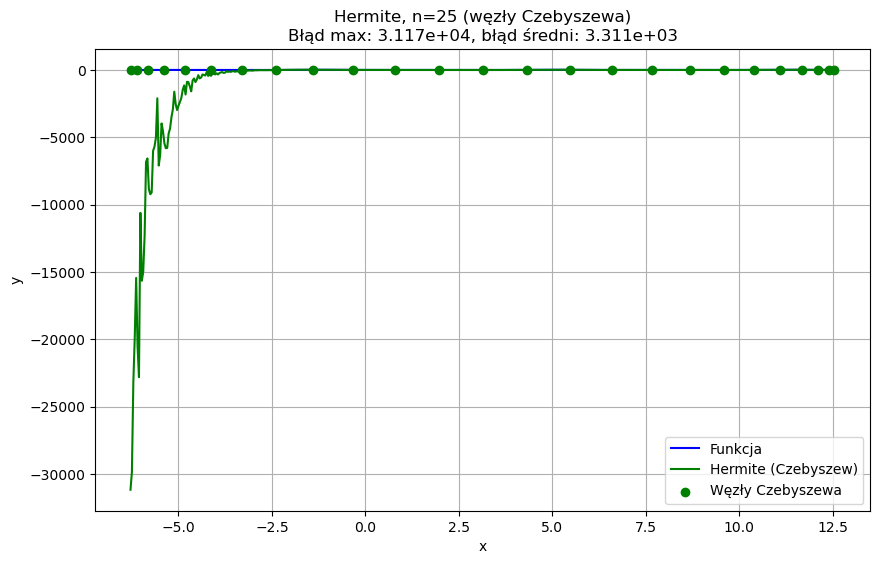


Interpolacja Hermite'a, n = 26


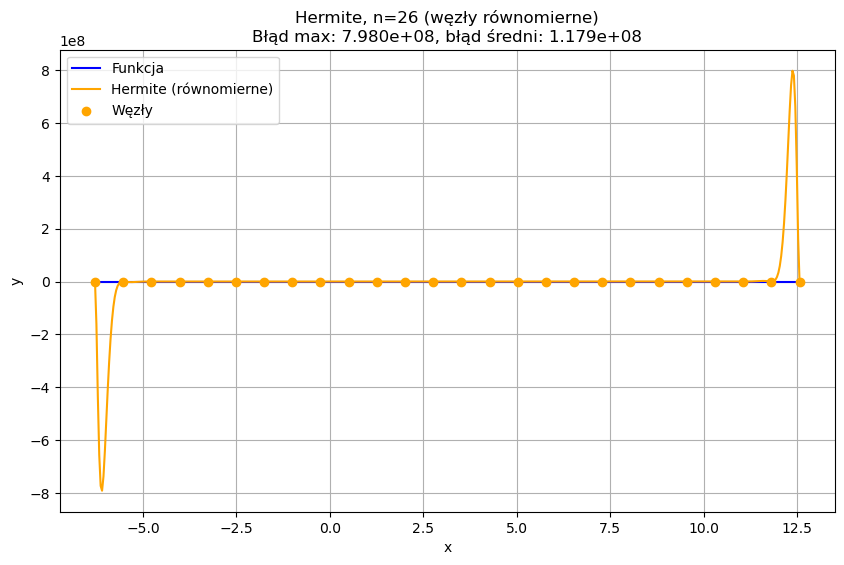

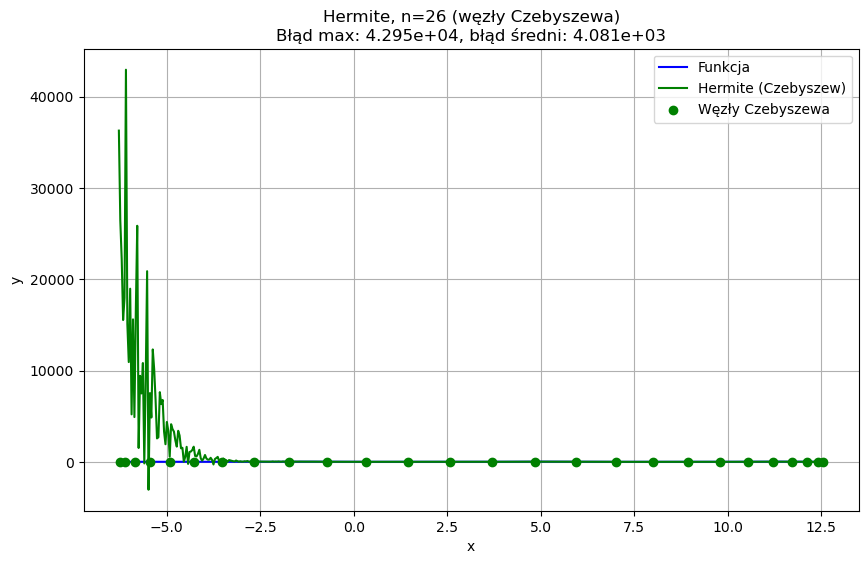


Interpolacja Hermite'a, n = 27


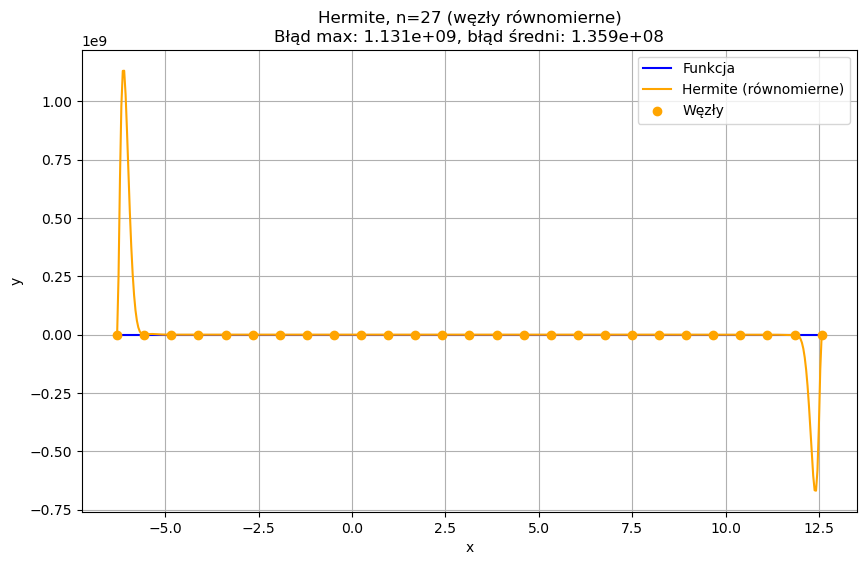

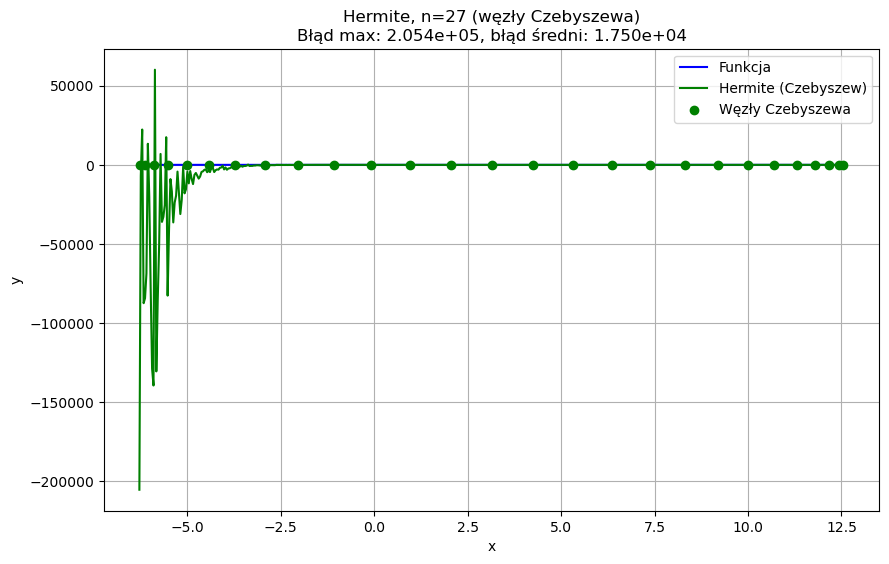


Interpolacja Hermite'a, n = 28


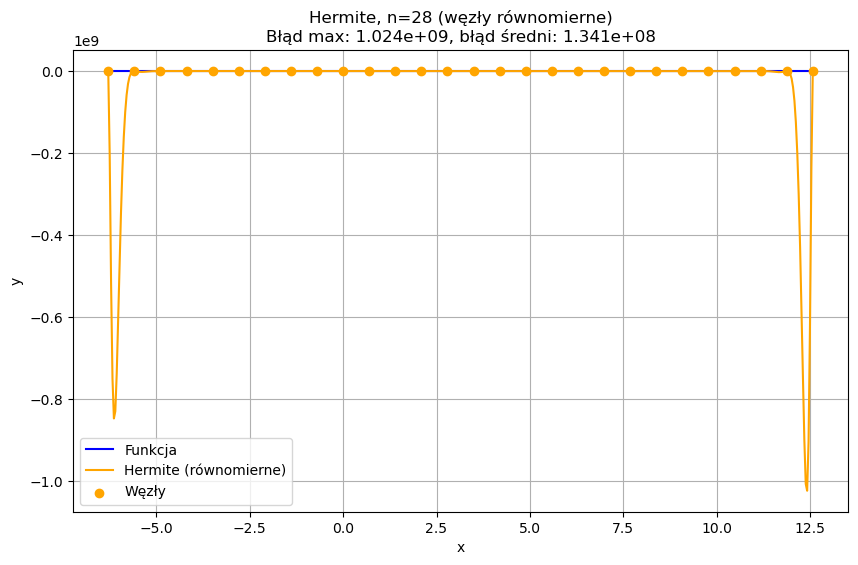

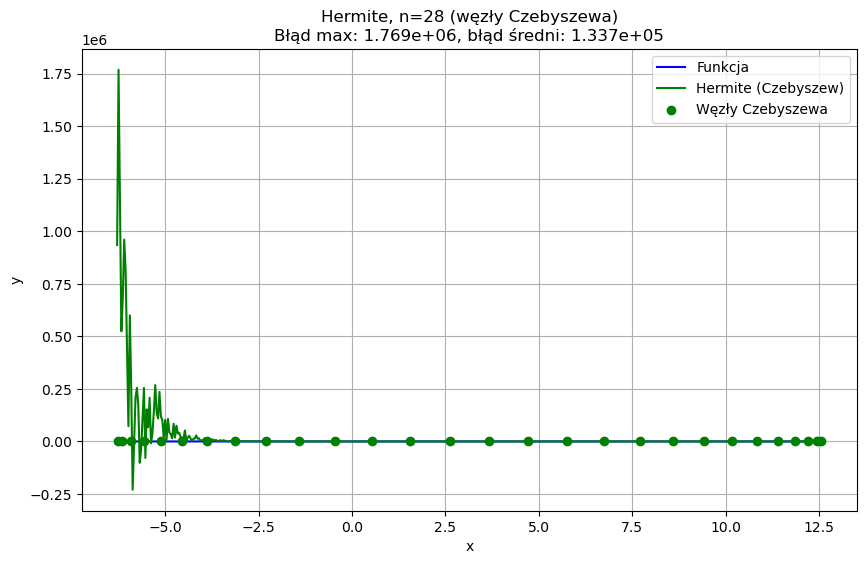


Interpolacja Hermite'a, n = 29


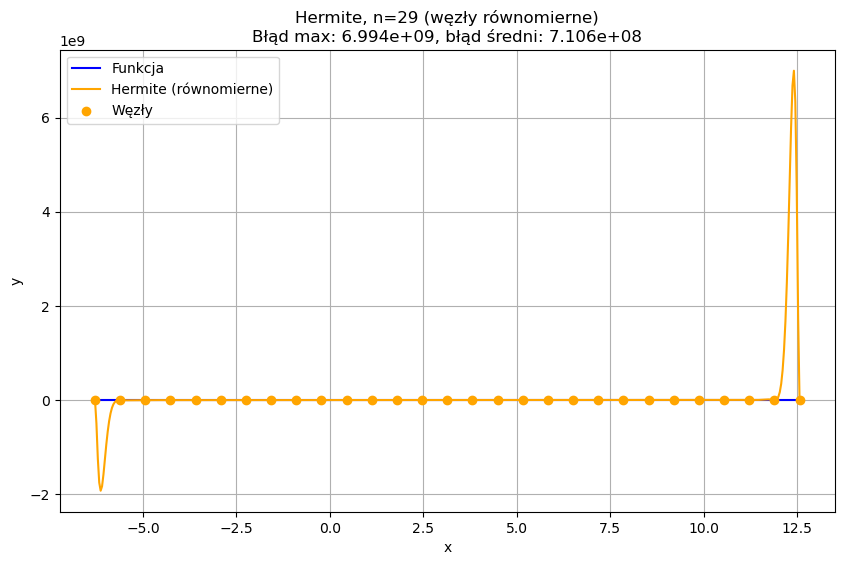

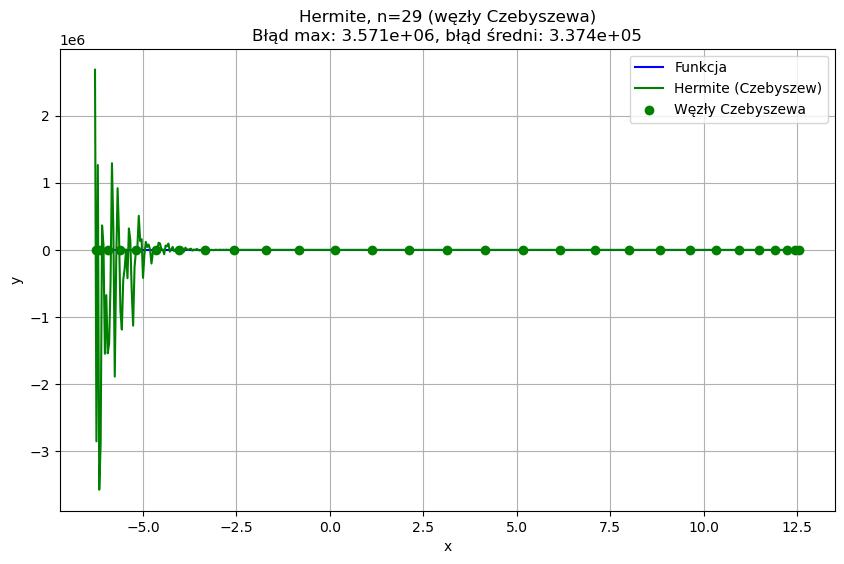


Interpolacja Hermite'a, n = 30


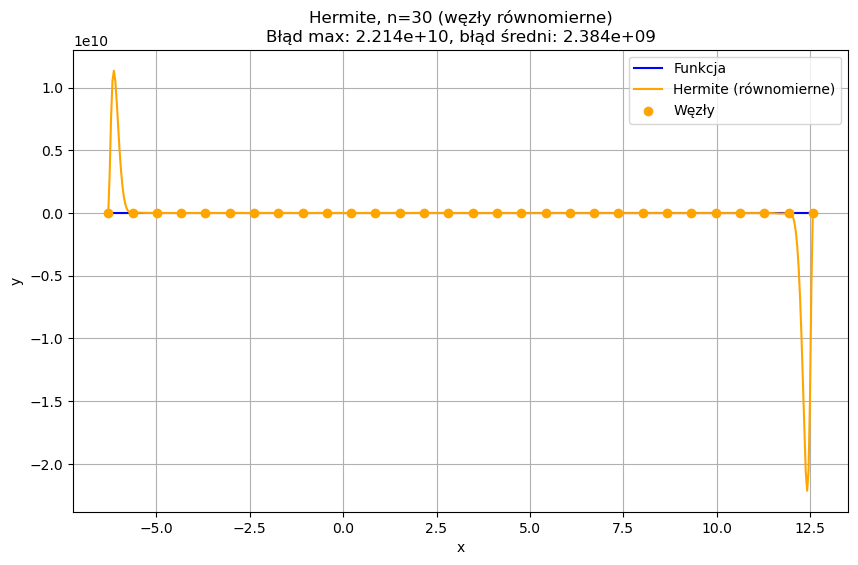

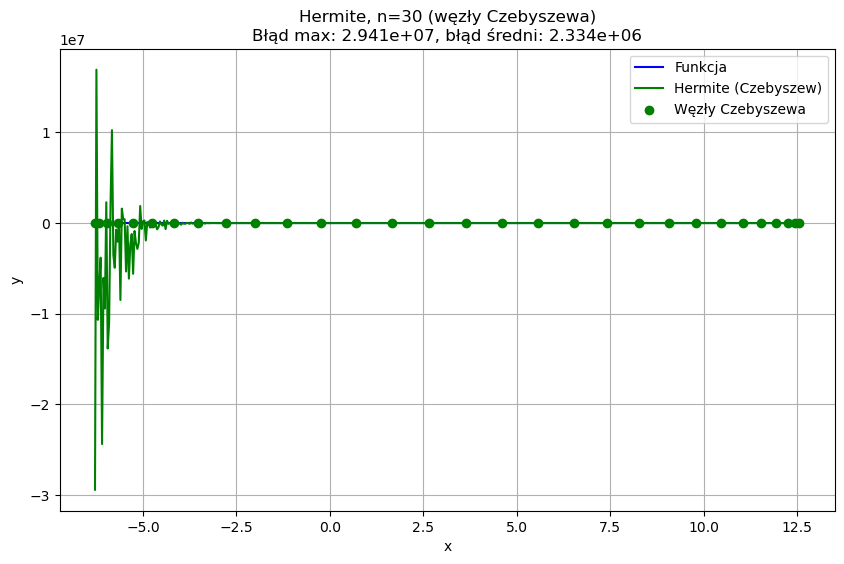


Interpolacja Hermite'a, n = 31


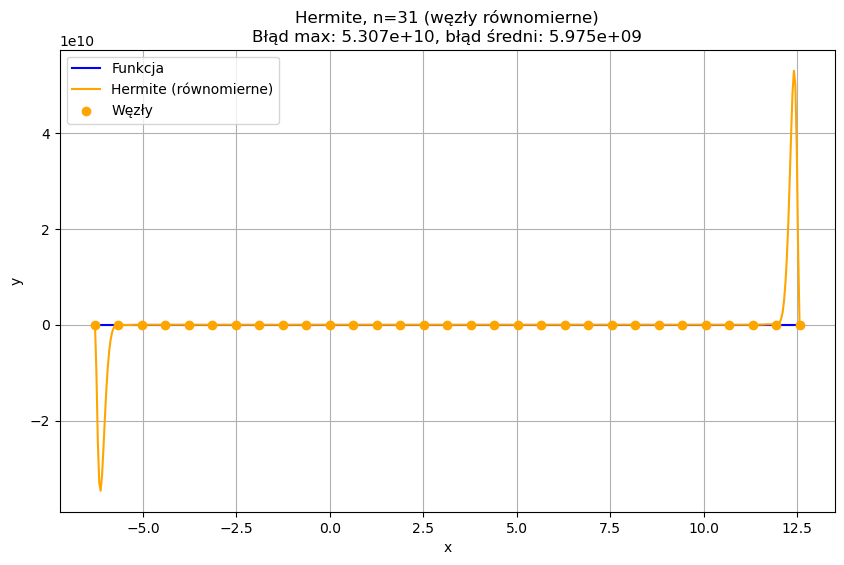

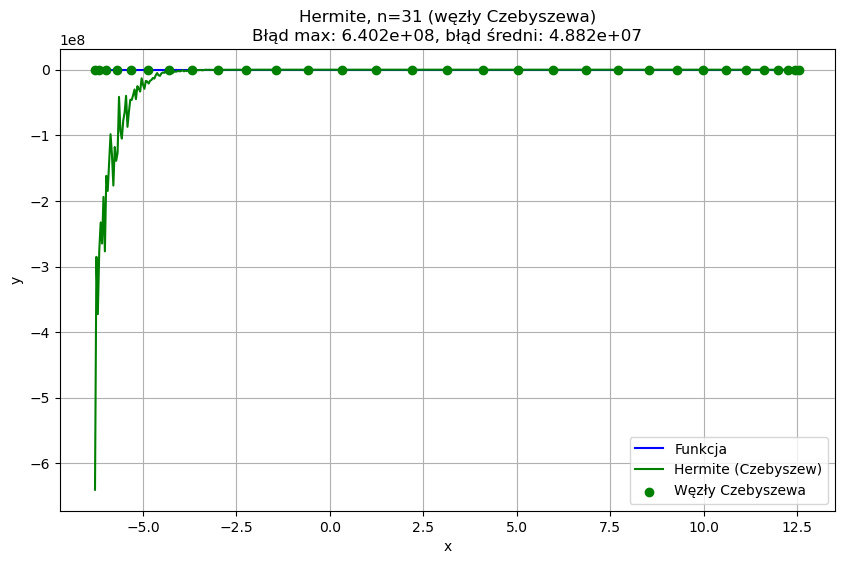


Interpolacja Hermite'a, n = 32


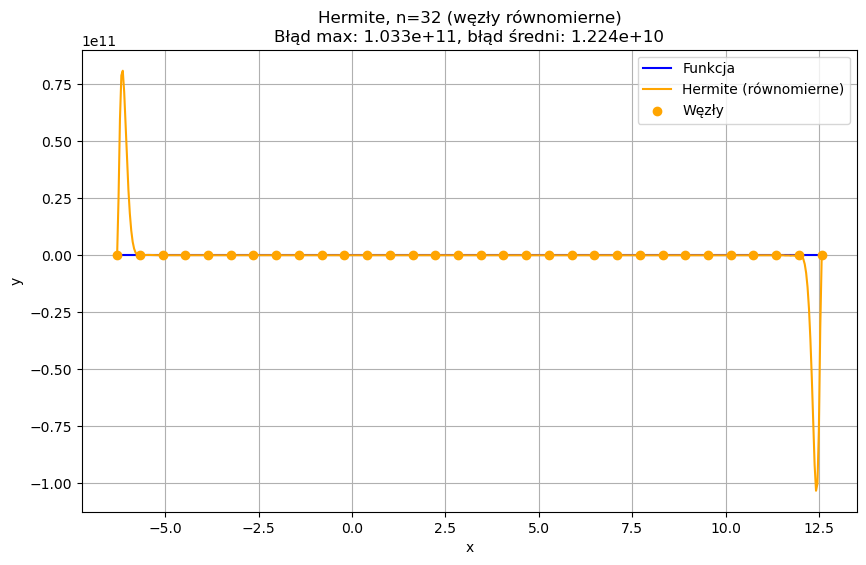

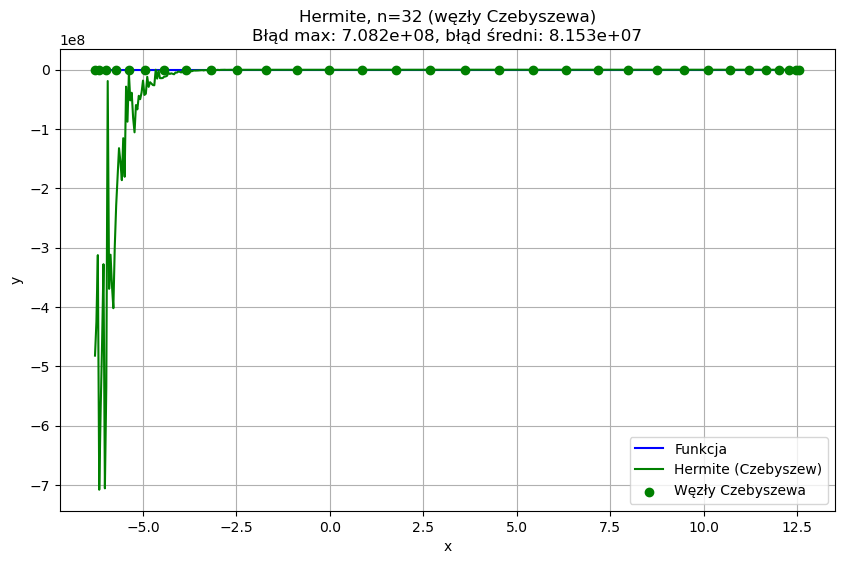


Interpolacja Hermite'a, n = 33


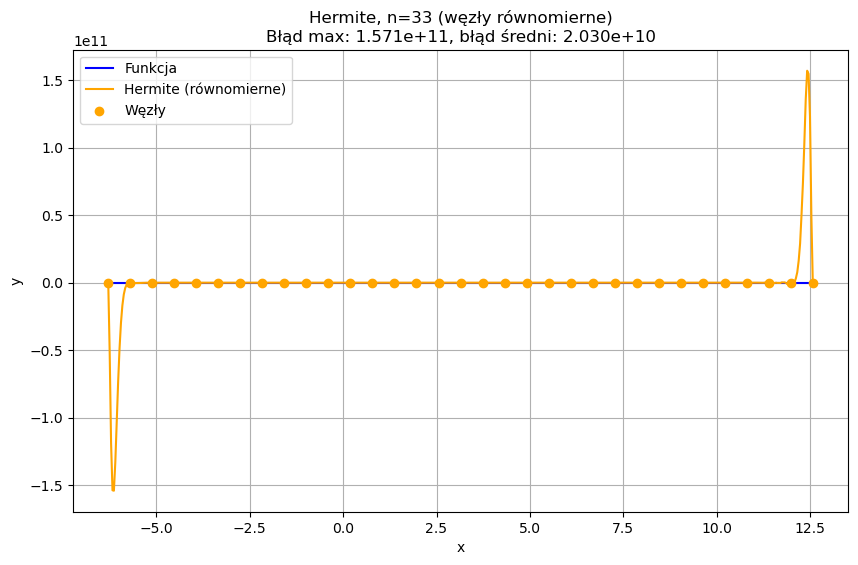

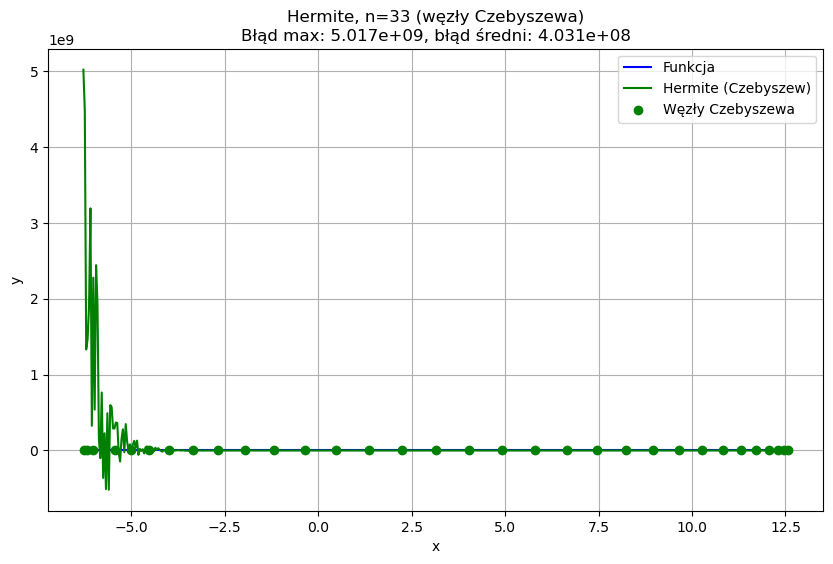


Interpolacja Hermite'a, n = 34


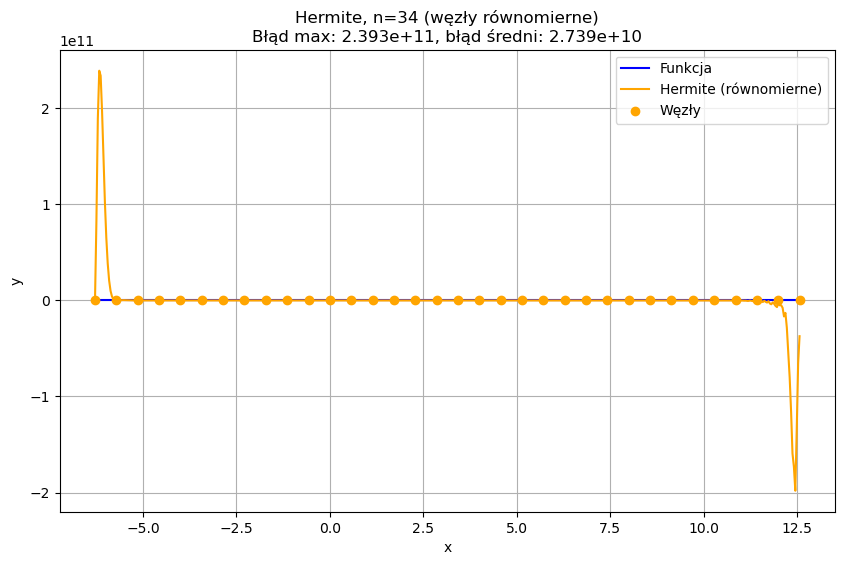

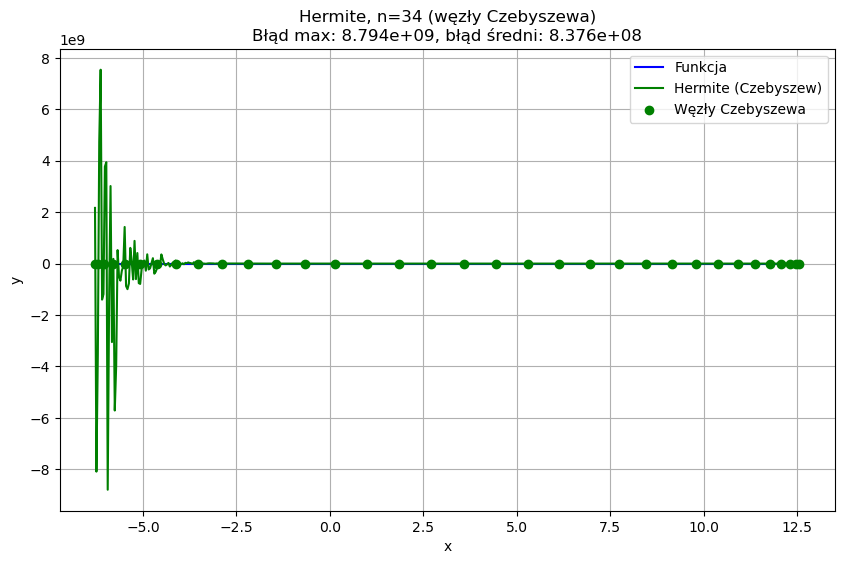


Interpolacja Hermite'a, n = 35


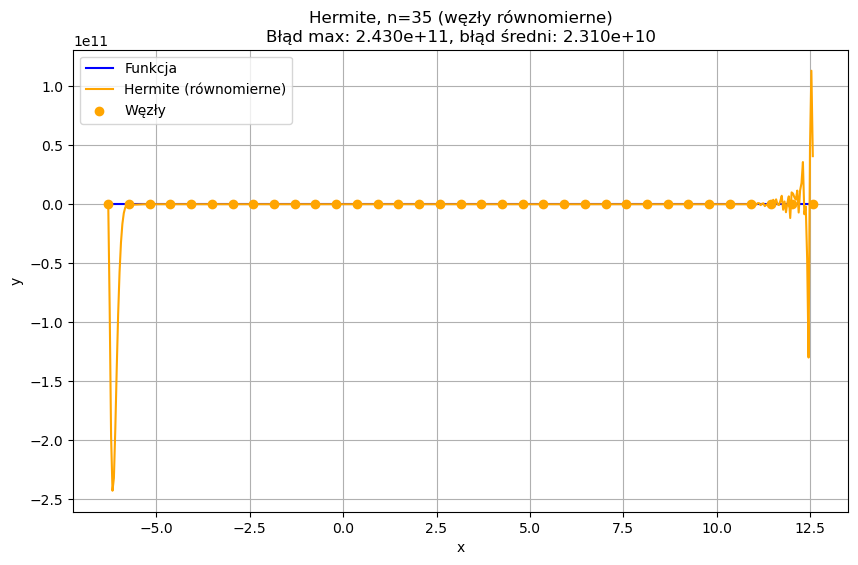

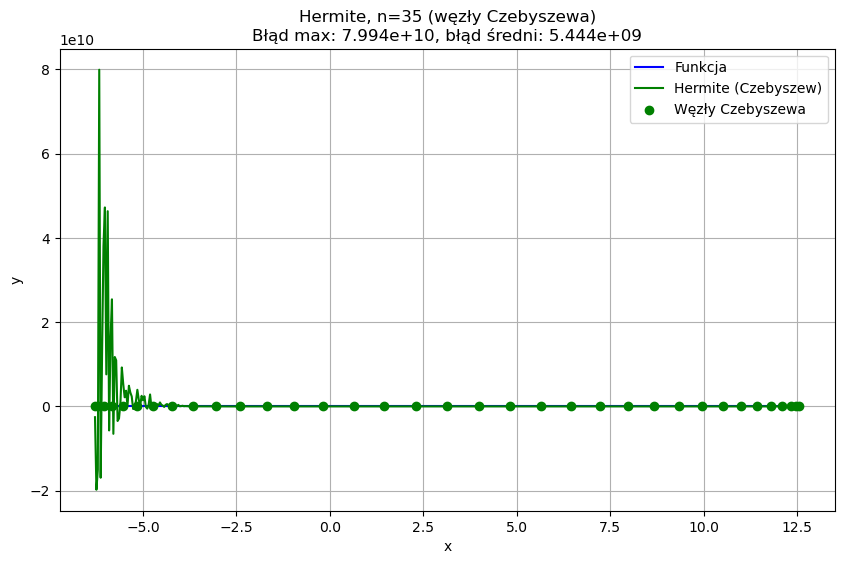


Interpolacja Hermite'a, n = 36


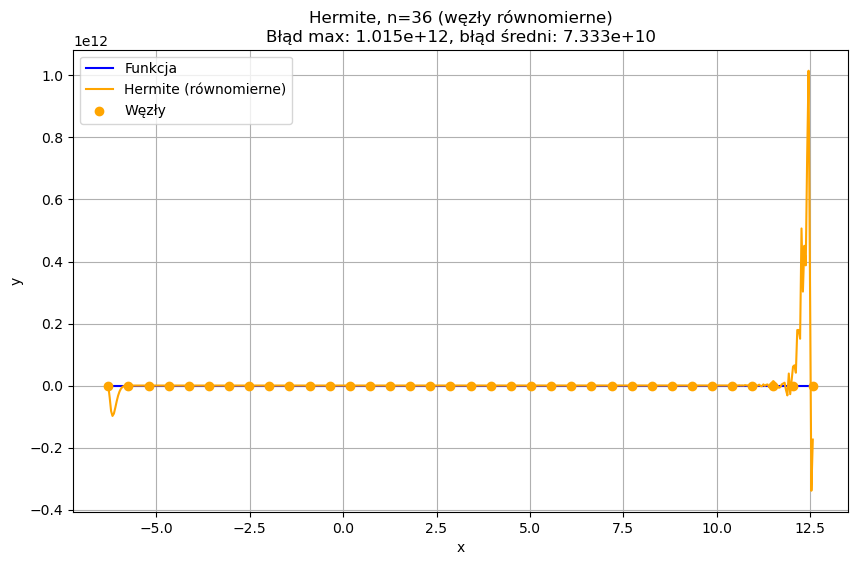

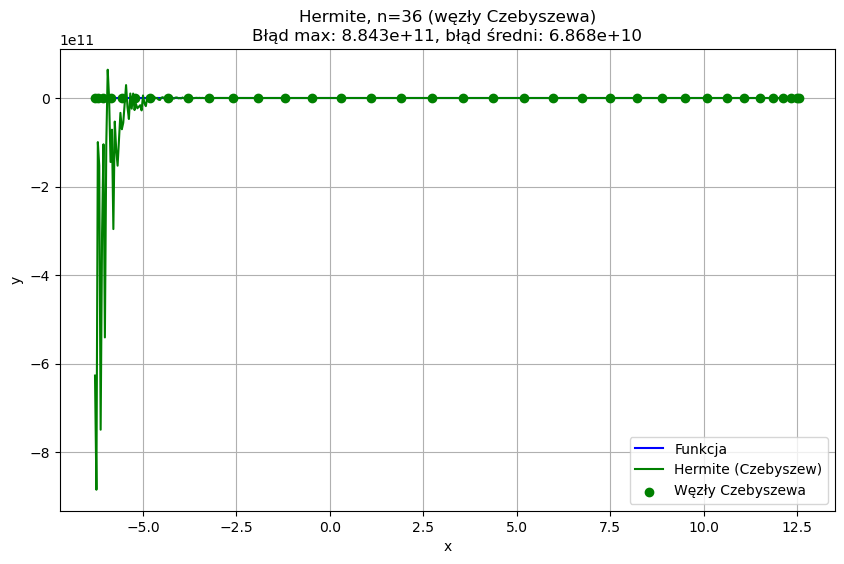


Interpolacja Hermite'a, n = 37


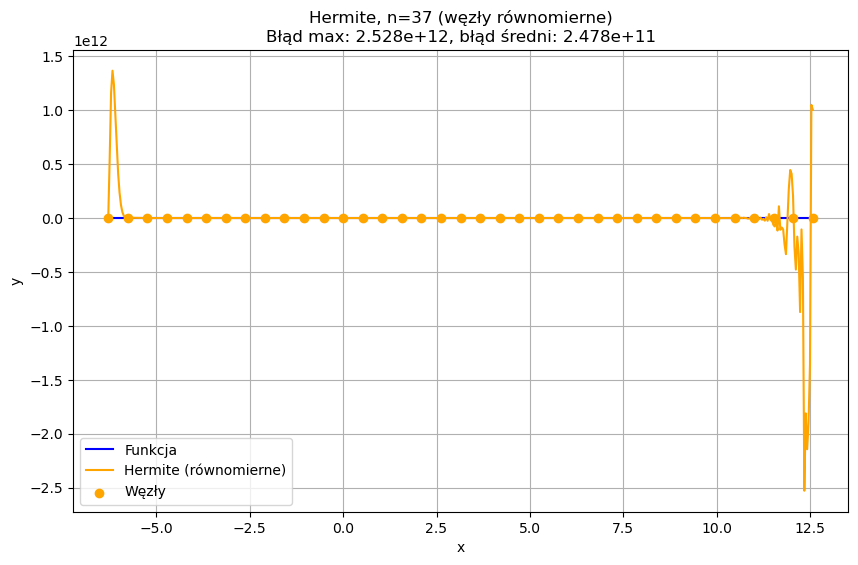

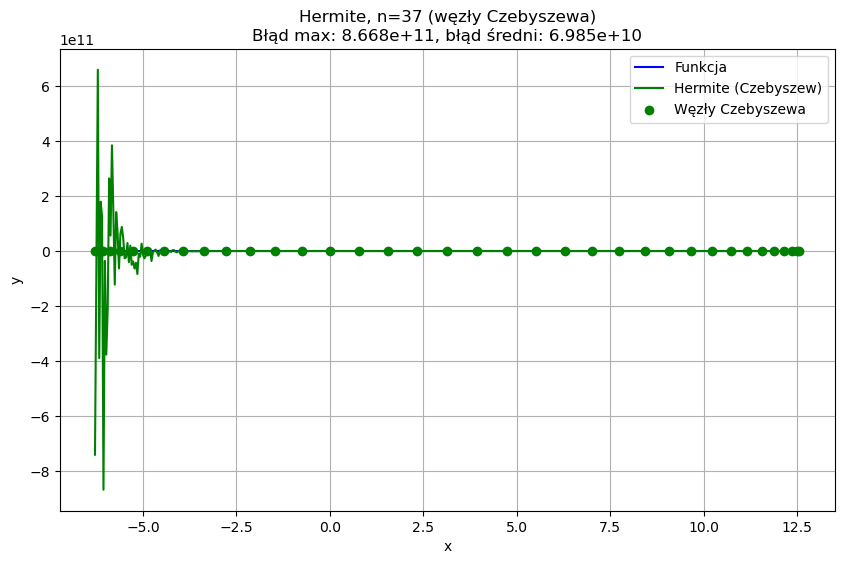


Interpolacja Hermite'a, n = 38


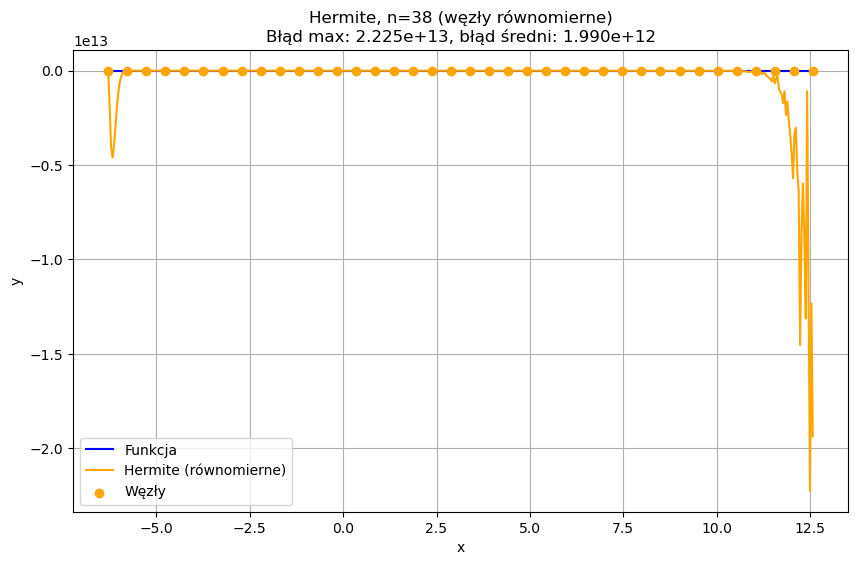

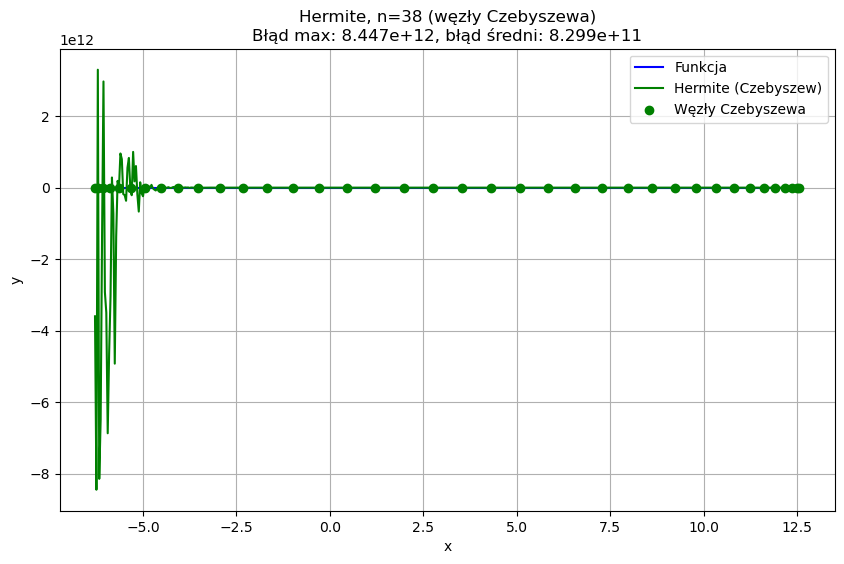


Interpolacja Hermite'a, n = 39


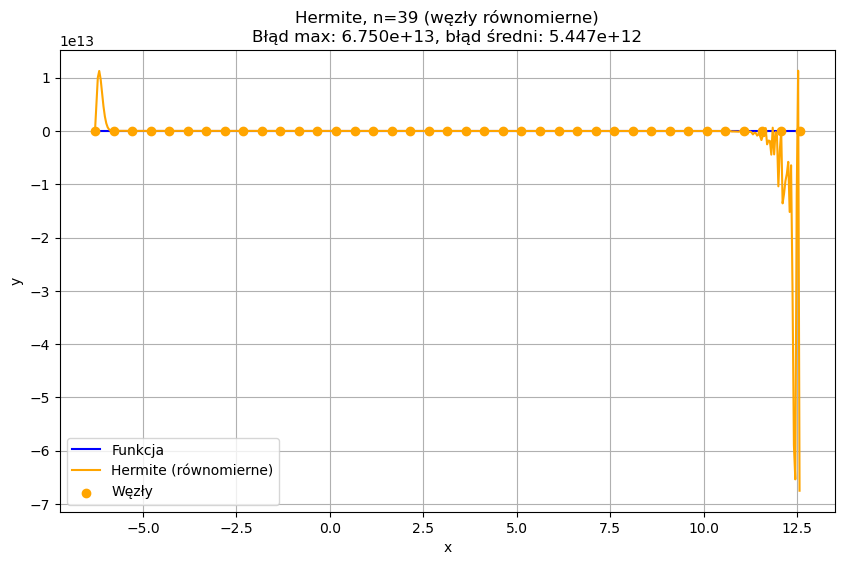

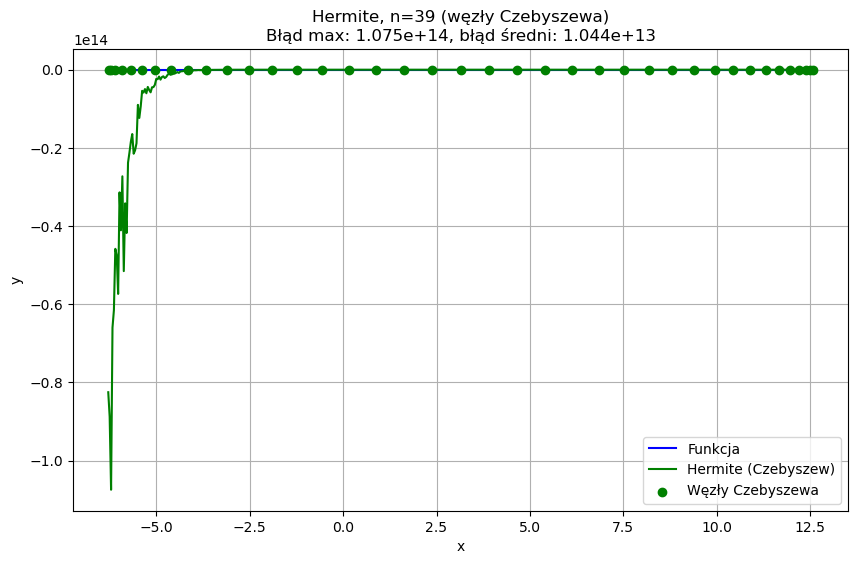


Interpolacja Hermite'a, n = 40


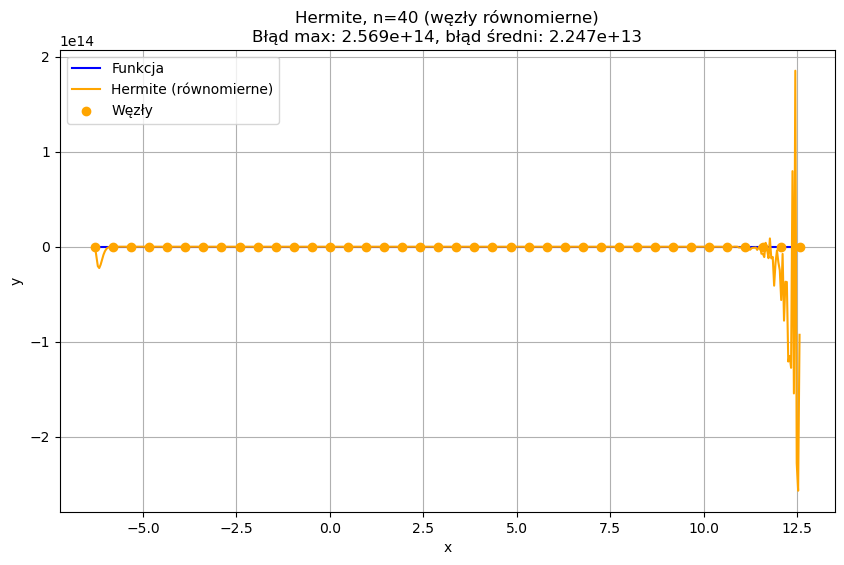

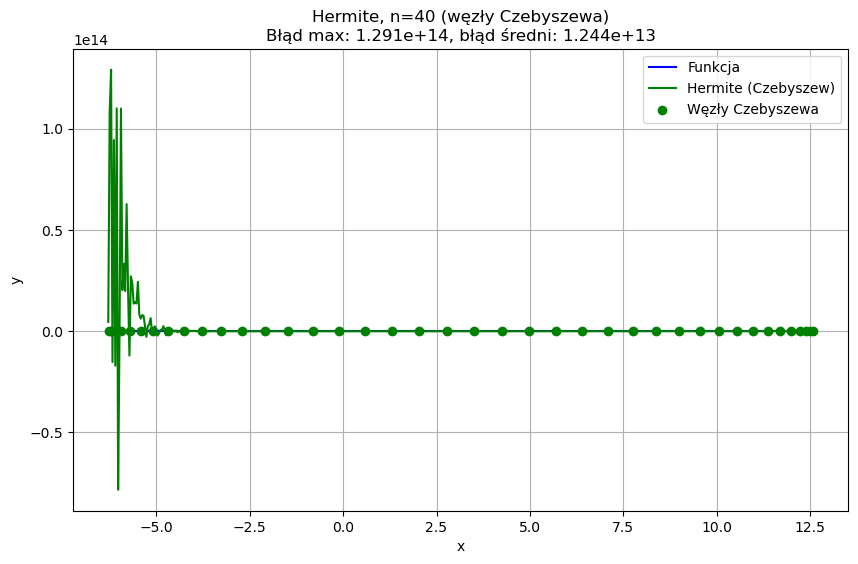


Interpolacja Hermite'a, n = 41


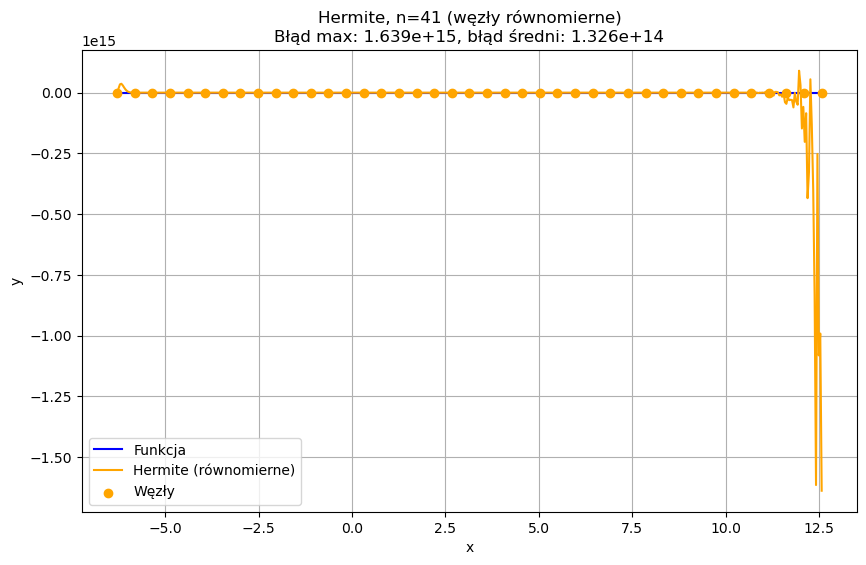

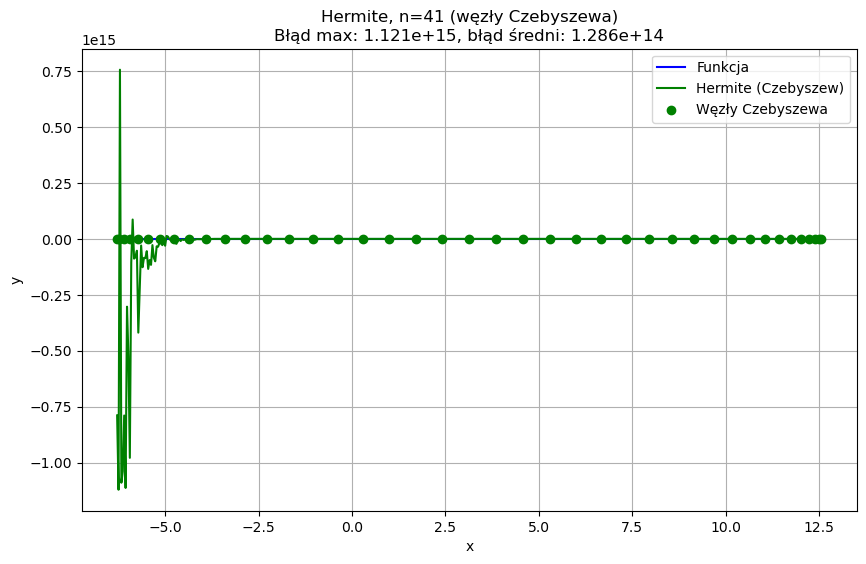


Interpolacja Hermite'a, n = 42


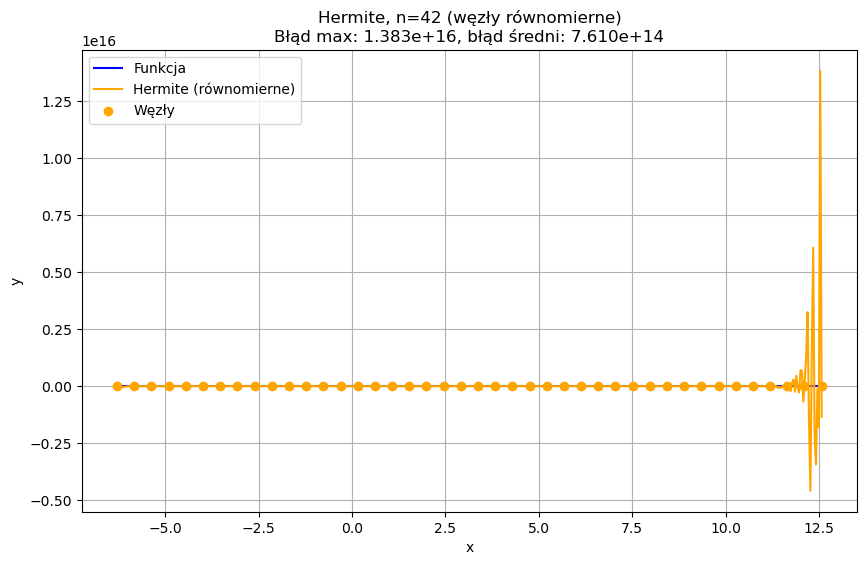

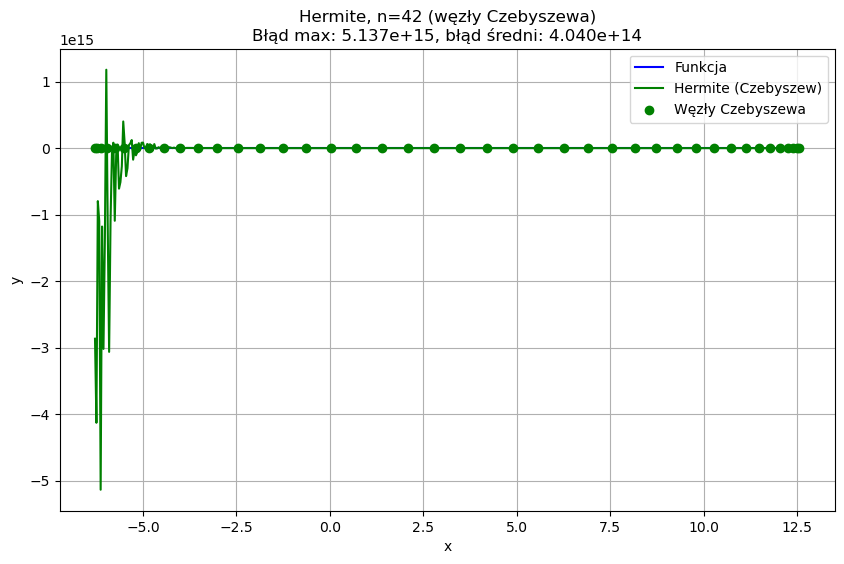


Interpolacja Hermite'a, n = 43


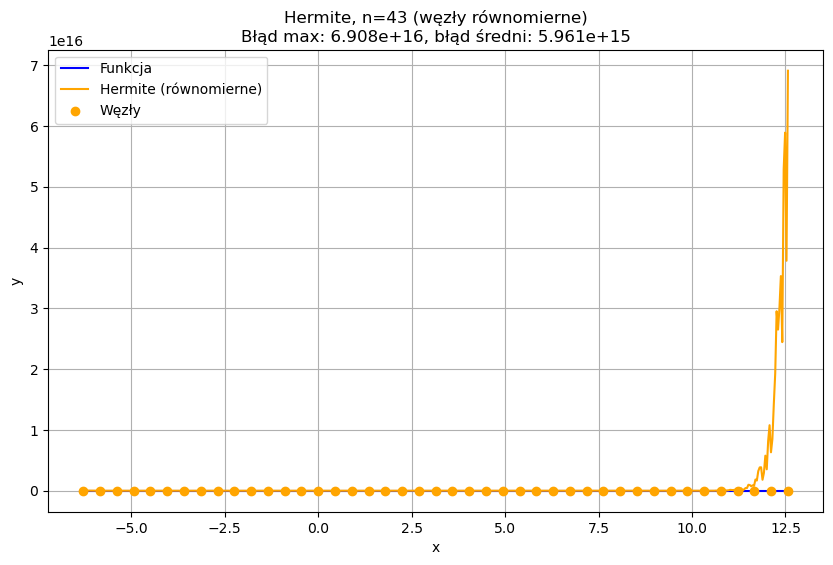

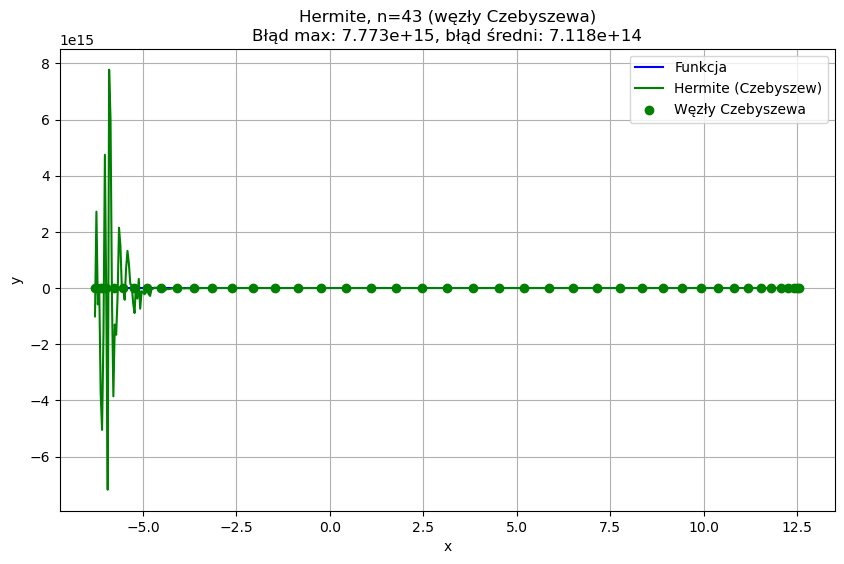


Interpolacja Hermite'a, n = 44


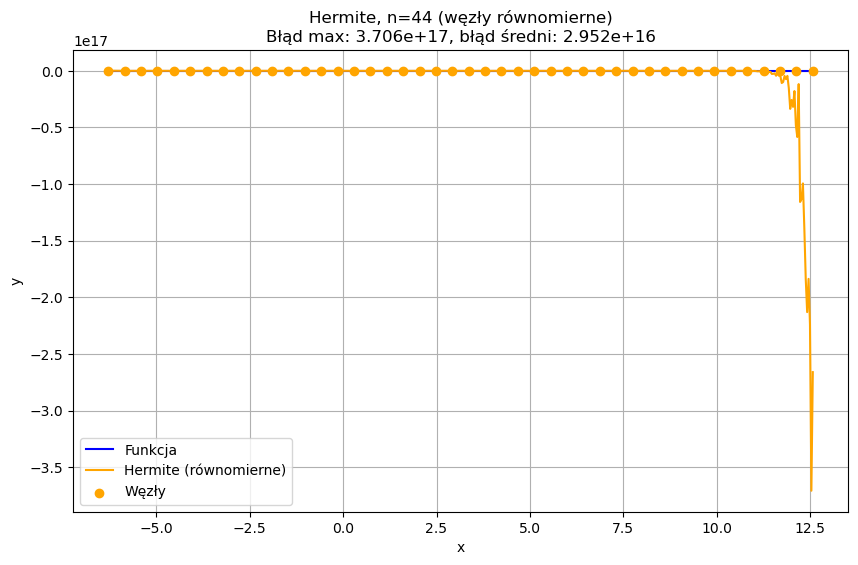

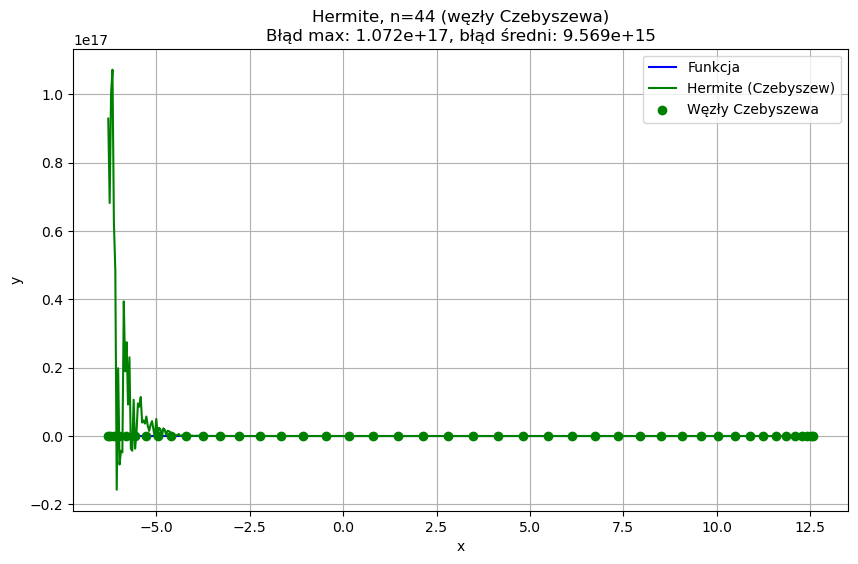


Interpolacja Hermite'a, n = 45


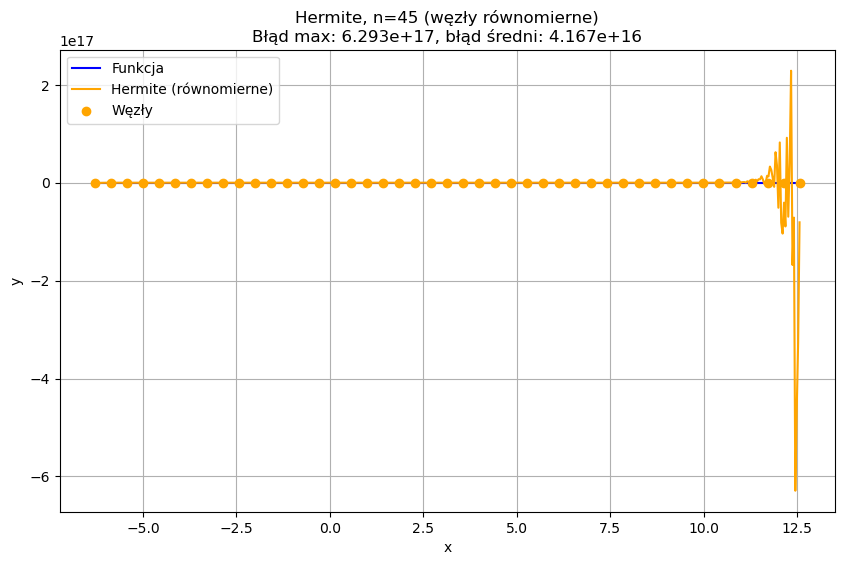

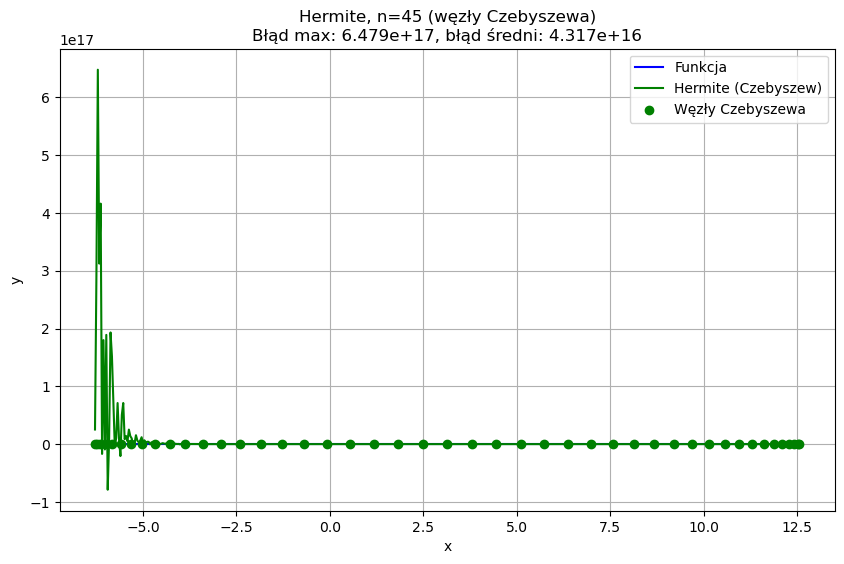


Interpolacja Hermite'a, n = 46


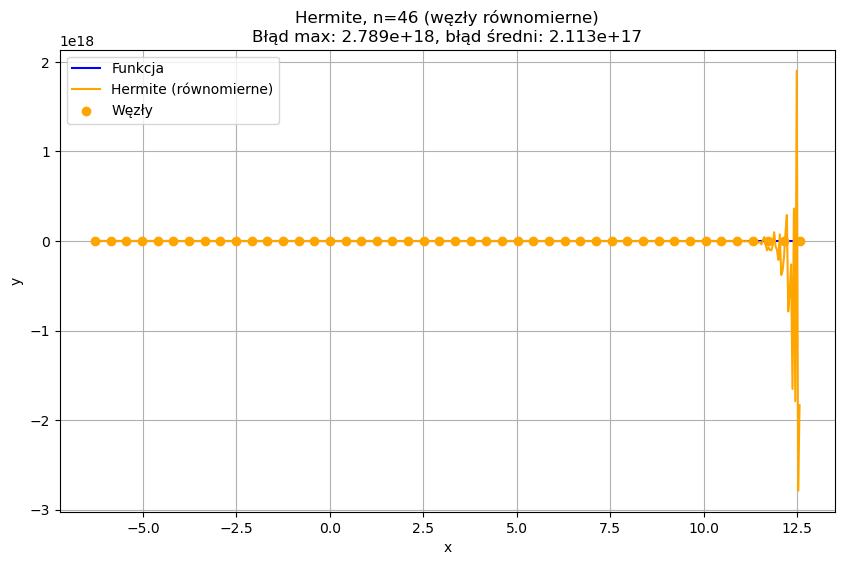

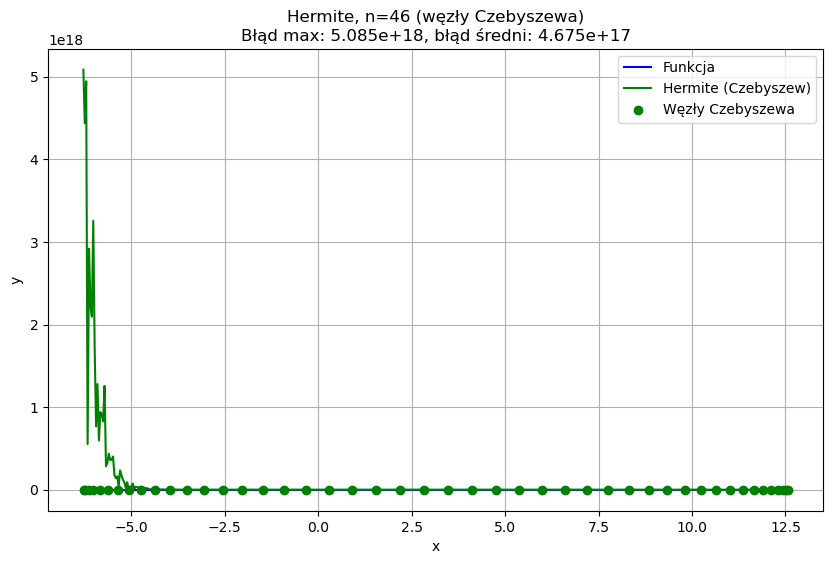


Interpolacja Hermite'a, n = 47


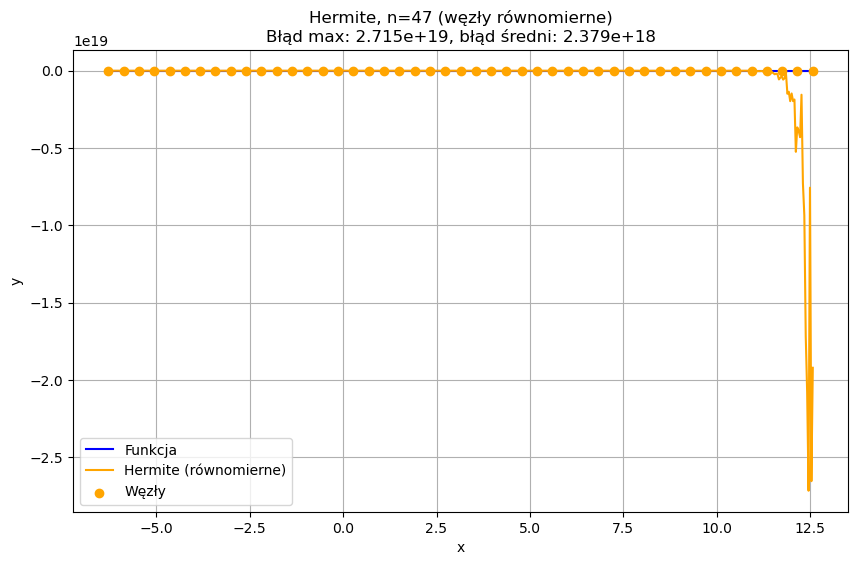

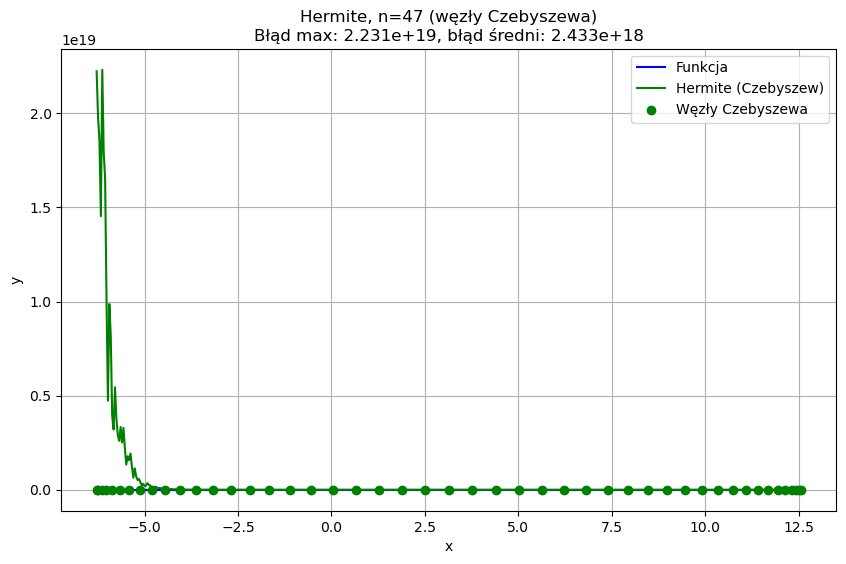


Interpolacja Hermite'a, n = 48


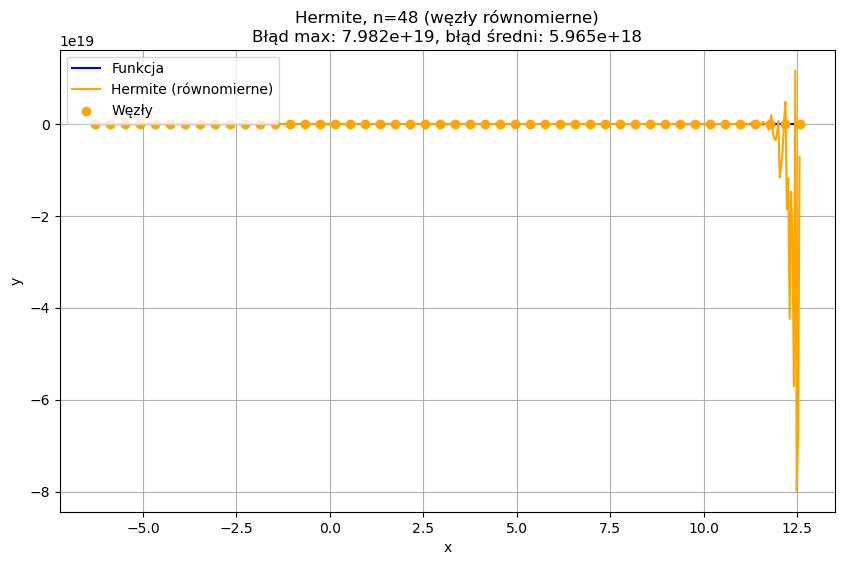

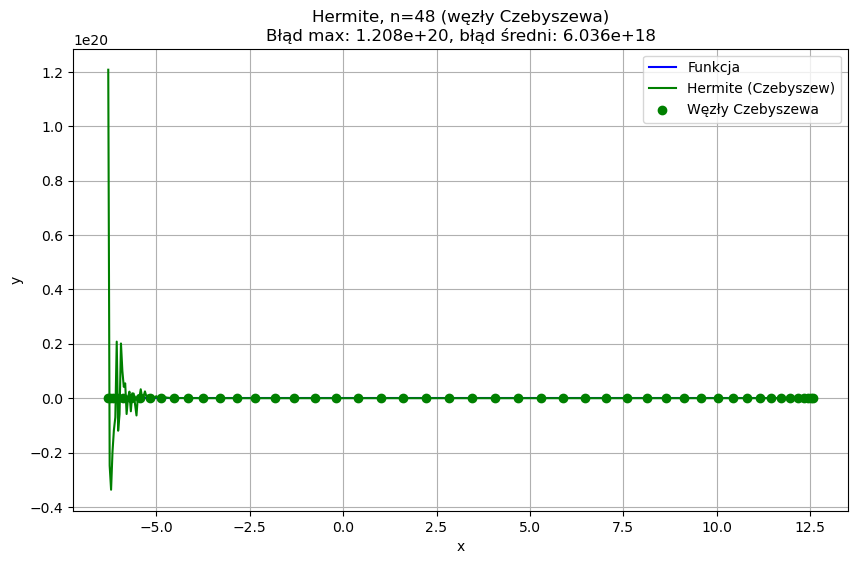


Interpolacja Hermite'a, n = 49


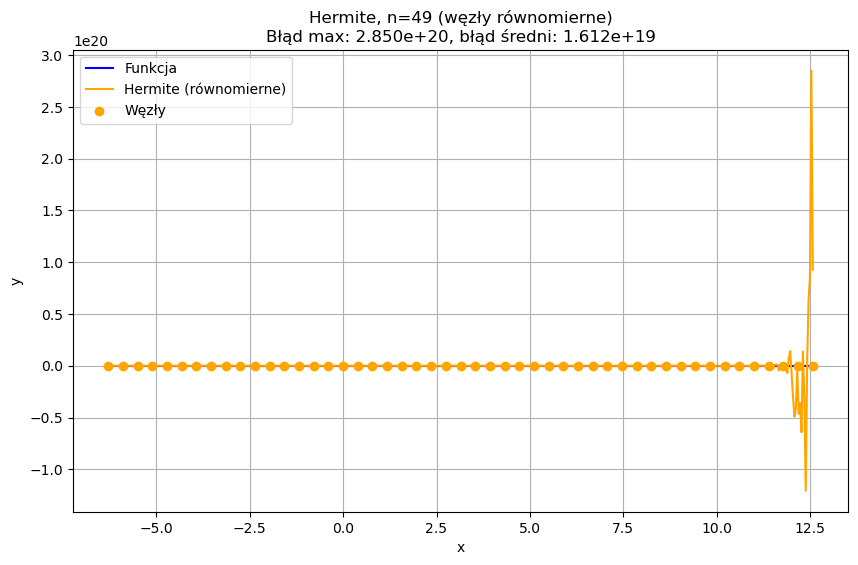

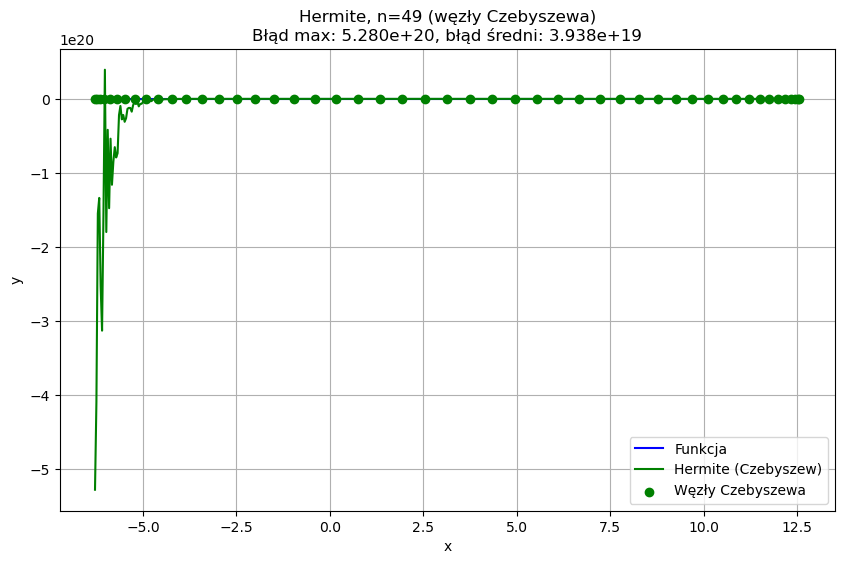


Interpolacja Hermite'a, n = 50


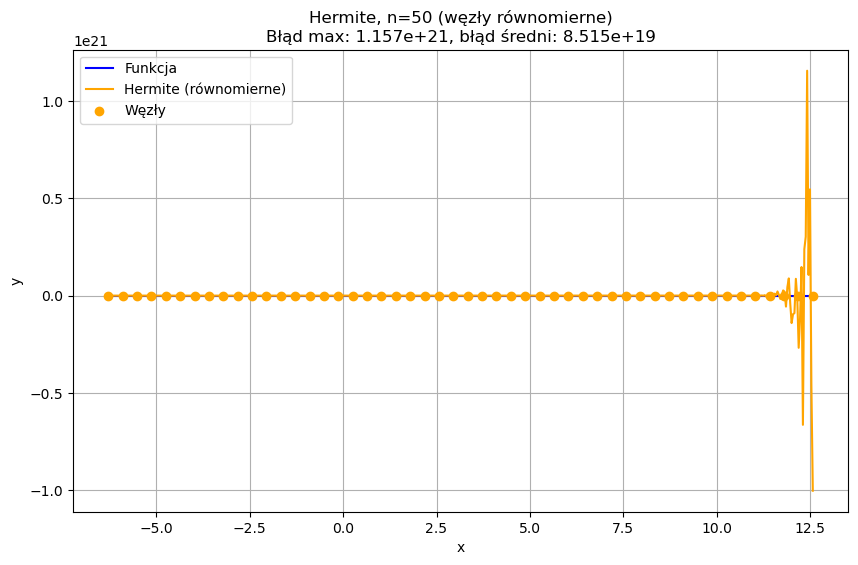

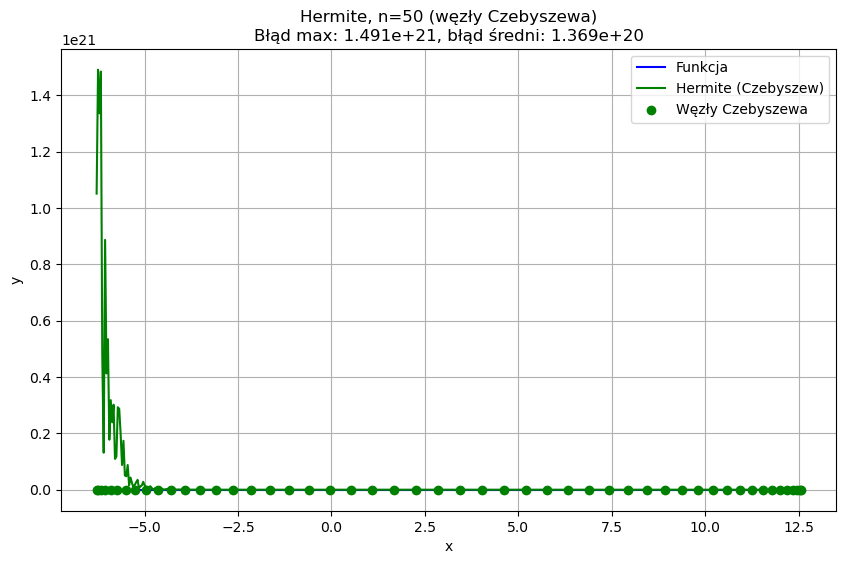

In [19]:
a = -2*math.pi
b =  4*math.pi

# Otwieramy plik CSV do zapisu:
with open("hermite_errors.csv", mode="w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    # Nagłówek
    csv_writer.writerow(["n", "Metoda interpolacji", "Rodzaj węzłów", "Błąd średni", "Błąd maksymalny"])

    for n in range(3,51):
        print(f"\nInterpolacja Hermite'a, n = {n}")

        plot_interpolation_hermite_uniform(a, b, n, func, func_derivative, csv_writer=csv_writer)

        plot_interpolation_hermite_chebyshev(a, b, n, func, func_derivative, csv_writer=csv_writer)